In [1]:

import torch
from functools import partial
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
from adjustText import adjust_text
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

PALETTE = 'Set2'

HUE_ORDER = ['BioBERT',
            'BioDistilBERT',
            'BioMobileBERT',
            'TinyBioBERT',
            'Llama-2-7b']

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",
                      "ICD9-Triage": "ICD9-Triage",
                      "mimic-mp": "MIMIC MP",
                      "mimic-los": "MIMIC LoS",}

metric_name_mapping = { "f1_macro": "F1 macro",
                   "f1_micro": "F1 micro",
                   "f1": "F1",
                   "f1_weighted": "F1 weighted",
                    "roc_auc_macro": "AUROC Macro",}


MODEL_NAME_MAP = {'BioBERT': 'BioBERT', 'bio-distilbert': 'BioDistilBERT',
                  'bio-mobilebert': 'BioMobileBERT', 'tiny-biobert': 'TinyBioBERT',
                  'Llama-2-7b': 'Llama-2-7b',
                  'Llama-2-7b-hf': 'Llama-2-7b',
                    "roberta-base": "RoBERTa-base",
                    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
                    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
                    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
                    "mimic-roberta-base": "RoBERTa-mimic",
                    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
                    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
                    "Bio_ClinicalBERT": "BioClinicalBERT",
                    "sts_trf_roberta": "ST-TRF-RoBERTa",
                    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
                    "biobert-v1.1": "BioBERT",
                    "Llama-2-7b-hf": "Llama-2-7b",
                    "bert-base-uncased": "BERTbase",
                    "distilbert-base-uncased": "DistilBERTbase",
                    "mobilebert-uncased": "MobileBERT",
                    "prajjwal1/bert-tiny": "TinyBERT",
                    "tiny-biobert": "TinyBioBERT",
                    "tiny-clinicalbert": "TinyClinicalBERT",
                    "TinyBERT_General_4L_312D": "TinyBERT",
                    "bio-mobilebert": "BioMobileBERT",
                    "clinical-mobilebert": "ClinicalMobileBERT",
                    "bio-distilbert-uncased": "BioDistilBERT",
                    "clinical-distilbert": "ClinicalDistilBERT",}



This is a notebook to load in experiment tensorboard event files and format tables and plots for the results. It is going to be fairly machine dependent and will need to be modified to work on other machines:

**Use with caution**

# Function development

Put together some initial functions - must be run

In [2]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
    "Bio_ClinicalBERT": "BioClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
    "biobert-v1.1": "BioBERT",
    "Llama-2-7b-hf": "Llama-2-7b",
    "bert-base-uncased": "BERTbase",
    "distilbert-base-uncased": "DistilBERTbase",
    "mobilebert-uncased": "MobileBERT",
    "prajjwal1/bert-tiny": "TinyBERT",
    "tiny-biobert": "TinyBioBERT",
    "tiny-clinicalbert": "TinyClinicalBERT",
    "TinyBERT_General_4L_312D": "TinyBERT",
    "bio-mobilebert": "BioMobileBERT",
    "clinical-mobilebert": "ClinicalMobileBERT",
    "bio-distilbert-uncased": "BioDistilBERT",
    "clinical-distilbert": "ClinicalDistilBERT",

    }

def get_configs(logs_dir, modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(f"{logdir}/", extra_columns={'dir_name','wall_time'})
    df = reader.scalars
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(
        lambda x: partial(get_configs, logdir)(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')

    # we want to replace few_shot_n nan values with few_shot_n = "full"
    # check if few_shot_n is a column
    if "few_shot_n" in merged_df.columns:
        merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))

    # now map to a more suitable name
    merged_df["Model name"] = merged_df["Model name"].replace(long_model_name_mappings)
    
    # rename columns
    col_rename_map = {
        "task": "task",
        "peft_method": "PEFT method",
        # "few_shot_n": "",
    }
    
    # map the col renames
    merged_df = merged_df.rename(columns=col_rename_map)
    
    
    return merged_df

### Get number of trainable parameters for each model type



In [3]:
with open('../trainable_params.yaml', 'r') as f:
    trainable_params_mapping = yaml.load(f, yaml.FullLoader)

with open('../model_type_trainable_model_size.yaml', 'r') as f:
    model_type_size_mappings = yaml.load(f, yaml.FullLoader)

with open('../gpu_memory_needed.json', 'r') as f:
    gpu_memory_needed = yaml.load(f, yaml.FullLoader)

In [4]:
list(trainable_params_mapping.keys())

['bert-base-uncased',
 'distilbert-base-uncased',
 'dmis-lab/biobert-v1.1',
 'emilyalsentzer/Bio_ClinicalBERT',
 'google/mobilebert-uncased',
 'huawei-noah/TinyBERT_General_4L_312D',
 'meta-llama/Llama-2-7b-hf',
 'nlpie/bio-distilbert-uncased',
 'nlpie/bio-mobilebert',
 'nlpie/clinical-distilbert',
 'nlpie/clinical-mobilebert',
 'nlpie/distil-biobert',
 'nlpie/tiny-biobert',
 'nlpie/tiny-clinicalbert',
 'prajjwal1/bert-tiny',
 'roberta-base']

In [13]:
# run through each model and show the values for "Full"
for model in list(trainable_params_mapping.keys()):
    print(f"\n###{model}####:\n ")
    print(trainable_params_mapping[model]["Full"]["FLOPs"])
    



###bert-base-uncased####:
 
6.81e+08


###distilbert-base-uncased####:
 
3.41e+08


###dmis-lab/biobert-v1.1####:
 
6.81e+08


###emilyalsentzer/Bio_ClinicalBERT####:
 
6.81e+08


###google/mobilebert-uncased####:
 
1.62e+08


###huawei-noah/TinyBERT_General_4L_312D####:
 
3.66e+07


###meta-llama/Llama-2-7b-hf####:
 
5.18e+10


###nlpie/bio-distilbert-uncased####:
 
3.41e+08


###nlpie/bio-mobilebert####:
 
1.62e+08


###nlpie/clinical-distilbert####:
 
3.41e+08


###nlpie/clinical-mobilebert####:
 
1.62e+08


###nlpie/distil-biobert####:
 
3.41e+08


###nlpie/tiny-biobert####:
 
3.66e+07


###nlpie/tiny-clinicalbert####:
 
3.66e+07


###prajjwal1/bert-tiny####:
 
3.18e+06


###roberta-base####:
 
6.81e+08


In [53]:
model_type_size_mappings

{'bert': {'LORA': {'full_model_size_GB': 0.807065955363214,
   'full_model_size_MB': 826.4355382919312,
   'model_size_GB': 0.40349293500185013,
   'model_size_MB': 413.17676544189453,
   'n_trainable_params': 296450,
   'n_trainable_params_perc': 0.2737005318256615,
   'peft_full_model_size_GB': 0.40585894975811243,
   'peft_full_model_size_MB': 415.59956455230713,
   'peft_model_size_GB': 0.0011043623089790344,
   'peft_model_size_MB': 1.1308670043945312,
   'total_trainable_params': 108311810},
  'PREFIX_TUNING': {'full_model_size_GB': 0.807065955363214,
   'full_model_size_MB': 826.4355382919312,
   'model_size_GB': 0.40349293500185013,
   'model_size_MB': 413.17676544189453,
   'n_trainable_params': 185858,
   'n_trainable_params_perc': 0.17159532279997905,
   'peft_full_model_size_GB': 0.4061121502891183,
   'peft_full_model_size_MB': 415.85884189605713,
   'peft_model_size_GB': 0.0006923750042915344,
   'peft_model_size_MB': 0.7089920043945312,
   'total_trainable_params': 10831

## Load in tensorboard events files



In [4]:
# logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/' # original with single run for all models
# updated with multi run
logs_dir = '/mnt/sdh/effecient_ml/logs_multiseed/' # crude but needs final /
logs_df = read_tb_files(logs_dir)

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/72912 [00:00<?, ?it/s]

### investigate files

In [7]:
logs_df.head()

,step,tag,value,wall_time,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,4,eval/accuracy,0.142857,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
1,8,eval/accuracy,0.142857,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
2,12,eval/accuracy,0.142857,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
3,16,eval/accuracy,0.133929,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
4,20,eval/accuracy,0.107143,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT


In [10]:
logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'random_seed', 'remove_columns',
       'save_adapter', 'save_every_steps', 'saving_strategy', 'scheduler_type',
       'task', 'task_to_keys', 'task_type', 'test_file', 'text_col',
       'text_column

In [ ]:
logs_df.model_name_or_path.unique()

array(['nlpie/bio-mobilebert', 'dmis-lab/biobert-v1.1',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'nlpie/tiny-biobert',
       'nlpie/tiny-clinicalbert', 'bert-base-uncased',
       'prajjwal1/bert-tiny', 'distilbert-base-uncased',
       'google/mobilebert-uncased', 'roberta-base'], dtype=object)

In [ ]:
logs_df["Model name"].unique()

array(['bio-mobilebert', 'BioBERT', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [ ]:
# check unique tasks 
logs_df.task.value_counts()

task
i2b2-2014-NER    33255
mimic-mp         25110
mimic-los        22590
i2b2-2010-RE     16875
ICD9-Triage       7920
i2b2-2012-NER     5715
i2b2-2010-NER     5670
Name: count, dtype: int64

In [60]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'eval/f1', 'test/f1'], dtype=object)

In [ ]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250])

In [ ]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,299,eval/accuracy,0.925498,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
1,598,eval/accuracy,0.940912,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
2,897,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
3,1196,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
4,1495,eval/accuracy,0.949261,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115517,5310,test/f1_macro,0.472474,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115518,5310,test/f1_micro,0.895642,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115519,5310,test/f1_weighted,0.846336,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115521,5310,test/precision,0.447821,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert


In [ ]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name


## Pull out metrics etc

In [5]:
def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df.loc[logs_df['tag'].str.contains('|'.join(metrics))]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

In [6]:
def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "max",
                            log_collection = "all", # | span

                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        # tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"eval/",'')
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"test/",'')
        
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

Below will retrieve all metrics of choice for each task and return the max

In [6]:
cls_results_df = produce_results_table(logs_df, 
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second",
                                        'eval/runtime', 'eval/samples_per_second'],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method","random_seed"], # random seed for multi runs
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

NameError: name 'produce_results_table' is not defined

In [8]:
cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,random_seed,accuracy,eval/accuracy,eval/f1_macro,...,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,12,0.944830,0.946692,0.876409,...,0.944830,0.945779,0.854893,0.878687,0.992491,1.178996e+16,0.175099,1149.644897,41.574001,1.300
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,34,0.946091,0.952794,0.892610,...,0.946091,0.946635,0.859058,0.869305,0.993235,1.178996e+16,0.179856,1152.969360,41.453999,1.297
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,56,0.944830,0.948619,0.876658,...,0.944830,0.945279,0.855896,0.874392,0.991585,1.178996e+16,0.184678,1146.529053,41.687000,1.304
3,3,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,12,0.912989,0.914579,0.724355,...,0.912989,0.903672,0.797014,0.681152,0.985789,1.179958e+16,0.509022,948.929810,50.367001,1.575
4,4,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,34,0.914250,0.913616,0.714745,...,0.914250,0.906057,0.820862,0.692292,0.985933,1.179958e+16,0.496816,950.845703,50.265999,1.572


In [ ]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
      dtype=object)

In [56]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'PEFT method', 'random_seed', 'accuracy', 'eval/accuracy',
       'eval/f1_macro', 'eval/f1_micro', 'eval/f1_weighted', 'eval/precision',
       'eval/recall', 'eval/roc_auc_macro', 'eval/runtime',
       'eval/samples_per_second', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'PEFT_params', 'PEFT_params_perc', 'Total_params', 'full_model_size_GB',
       'full_model_size_MB', 'peft_full_model_size_GB',
       'peft_full_model_size_MB'],
      dtype='object', name='tag')

In [40]:
cls_results_df["model_name_or_path"].unique()

array(['bert-base-uncased', 'dmis-lab/biobert-v1.1',
       'emilyalsentzer/Bio_ClinicalBERT', 'distilbert-base-uncased',
       'meta-llama/Llama-2-7b-hf', 'roberta-base',
       'huawei-noah/TinyBERT_General_4L_312D',
       'nlpie/bio-distilbert-uncased', 'nlpie/bio-mobilebert',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'google/mobilebert-uncased',
       'nlpie/tiny-biobert', 'nlpie/tiny-clinicalbert'], dtype=object)

In [44]:
cls_results_df["Model name"].unique()

array(['BERTbase', 'BioBERT', 'BioClinicalBERT', 'BioDistilBERT',
       'BioMobileBERT', 'ClinicalDistilBERT', 'ClinicalMobileBERT',
       'DistilBERTbase', 'Llama-2-7b', 'MobileBERT', 'RoBERTa-base',
       'TinyBERT', 'TinyBioBERT', 'TinyClinicalBERT', 'distil-biobert'],
      dtype=object)

### trainable_params_mapping

In [59]:
trainable_params_mapping['nlpie/tiny-biobert']["Full"]

{'n_peft_params': 13874136,
 'n_peft_params_perc': 99.99548821089688,
 'total_params': 13874762}

In [11]:
cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)
cls_results_df['full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_GB', np.NaN), axis=1)
cls_results_df['full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_MB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_MB', np.NaN), axis=1)


In [12]:
# get remaining NER
ner_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method", "random_seed"],
                                        task_type = "TOKEN_CLS",
                                        value_aggregate_method = "max",
                                        )

In [12]:
ner_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,random_seed,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,12.0,0.830870,0.851808,0.477532,0.492891,0.464101,0.475029,0.502972,0.450027
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,34.0,0.829707,0.850812,0.473423,0.490476,0.458179,0.470815,0.498927,0.445703
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,56.0,0.831513,0.850911,0.463846,0.482786,0.446336,0.473074,0.502161,0.447172
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,12.0,0.905214,0.921422,0.719969,0.745051,0.696521,0.696060,0.713149,0.679772
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,34.0,0.902597,0.923314,0.723340,0.742212,0.705403,0.693984,0.707952,0.680555


## Get pending tasks

In [76]:
# import datasets.yaml
import yaml
with open('../datasets.yaml', 'r') as f:
    dataset_mapping = yaml.load(f, yaml.FullLoader)

In [ ]:
# print keys of dataset
list(dataset_mapping.keys())

['mednli',
 'mimic-dia',
 'mimic-dia-adm-only',
 'mimic-los',
 'mimic-los-adm-only',
 'mimic-mp',
 'ICD9-Triage',
 'i2b2-2010-NER',
 'i2b2-2012-NER',
 'i2b2-2014-NER',
 'i2b2-2010-RE']

In [ ]:
cls_results_df.query("task == 'i2b2-2010-RE'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,Full,0.937744,0.676479,0.937744,0.937263,...,1395.907349,79.719002,2.493,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,IA3,0.893930,0.283517,0.893930,0.876678,...,1165.987549,95.438004,2.985,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,LORA,0.924116,0.404030,0.924116,0.916927,...,1188.701416,93.614998,2.928,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,PREFIX_TUNING,0.868140,0.161255,0.868140,0.817965,...,1096.670410,101.471001,3.173,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,PROMPT_TUNING,0.853651,0.102339,0.853651,0.786254,...,1147.976196,96.935997,3.031,7680,0.007091,108311810,0.403493,413.176765,0.403493,413.176765
24,24,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,Full,0.929349,0.530681,0.929349,0.925223,...,1210.822754,91.903999,2.874,24581888,99.995826,24582914,0.091578,93.776375,0.091578,93.776375
25,25,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,IA3,0.896721,0.297467,0.896721,0.880790,...,1109.573120,100.291000,3.136,58368,0.237433,24582914,0.091578,93.776375,0.091578,93.776375
26,26,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,LORA,0.918442,0.419853,0.918442,0.910261,...,1230.920654,90.403999,2.827,221184,0.899747,24582914,0.091578,93.776375,0.091578,93.776375
27,27,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,PROMPT_TUNING,0.853651,0.103397,0.853651,0.786514,...,941.981018,118.134003,3.694,1280,0.005207,24582914,0.091578,93.776375,0.091578,93.776375
39,39,distil-biobert,nlpie/distil-biobert,i2b2-2010-RE,250.0,Full,0.928512,0.555458,0.928512,0.927032,...,1165.526978,95.475998,2.986,65783040,99.997662,65784578,0.245067,250.948250,0.245067,250.948250


In [ ]:
from itertools import combinations, product, chain

In [ ]:
# find all combinations of models, tasks , pefts using itertools combinations

# def cartesian_product(*arr):
#     # product of all pairwise combinations
#     # of the input arrays
#     res = arr[0]
#     for i in range(1, len(arr)):
#         res = list(product(res, arr[i]))
        
#     return [r[0]+(r[1],) for r in res]

def cartesian_product(*arr):
    if len(arr) == 0:
        return []
    if len(arr) == 1:
        return [tuple([i]) for i in arr[0]]
    sub_product = cartesian_product(*arr[1:])
    return [(x,)+y for y in sub_product for x in arr[0]]
        
    # return res
    # return the list of all the computed tuple
    # using the product() method
    # return list(product(arr1, arr2))

def get_remaining_experiments(results_df:pd.DataFrame,
                              get_few_shot:bool = False):
    
    # get all the experiments that have been run
    # get all the combinations of models, tasks, pefts
    # get all the combinations of models, tasks, pefts that have been run
    # get the difference between the two sets
    # return the difference    
    
    # also get fewshot tasks if required
    if get_few_shot:
        cols = ["model_name_or_path", "task", "PEFT method", "few_shot_n"]
    else:
        cols = ["model_name_or_path", "task", "PEFT method"]
        # only get the full training set 
        results_df = results_df[results_df["few_shot_n"] == 250]
    
    arr = []
    for c in cols:
        arr.append(results_df[c].unique())
    
    combos = cartesian_product(*arr)
    
    new_df = results_df.set_index(cols)
    print(f"new_df.index.to_list(): {new_df.index.to_list()}")
    pending_tasks = set(combos).difference(set(new_df.index.to_list()))
    print(f'Pending tasks before subsetting: {len(pending_tasks)}')
    
    return pending_tasks, cols

### manual approach if no experiments have been run yet

In [ ]:
# create list of possible peft methods, models and tasks
# models = ["google/mobilebert-uncased",
#           "huawei-noah/TinyBERT_General_4L_312D",
#           "distilbert-base-uncased",
#           "emilyalsentzer/Bio_ClinicalBERT",
#           "bert-base-uncased",
#           ]

models = ["nlpie/bio-distilbert-uncased"]

# clinical models

# models = ["nlpie/clinical-mobilebert",
#           "nlpie/tiny-clinicalbert",
#           "nlpie/clinical-distilbert",]

# can subset tasks we want to look at here - at moment 01/12/23 we only need to run NER tasks as we have all the CLS tasks
tasks = [
        'MIMIC LoS',
        'MIMIC MP',
        'ICD9-Triage',
        'i2b2-2010-NER',
        'i2b2-2012-NER',
        'i2b2-2014-NER',
        'i2b2-2010-RE'
        ]
# pefts = ["LORA", "Full"] 
pefts = ["IA3"]

In [ ]:
cls_results_df["PEFT method"].unique()  

array(['Full', 'LORA', 'IA3', 'PREFIX_TUNING'], dtype=object)

### approach if experiments have been run

In [ ]:


models = cls_results_df["Model name"].unique()
tasks = cls_results_df["task"].unique()
pefts = cls_results_df["PEFT method"].unique()
few_shot_ns = cls_results_df["few_shot_n"].unique()
len(models), len(tasks), len(pefts), len(few_shot_ns)

(13, 4, 4, 1)

In [15]:
models, tasks

(array(['BioBERT', 'bio-mobilebert', 'distil-biobert', 'tiny-biobert'],
       dtype=object),
 array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
       dtype=object))

In [ ]:
# get all combinations of models, tasks, pefts and few_shot_ns

### for manual creation

In [68]:
# for manual creation
cols = ["model_name_or_path", "task", "PEFT method"]
pending_tasks = cartesian_product(models, tasks, pefts)
pending_tasks = pd.DataFrame(pending_tasks, columns=cols)

In [69]:
pending_tasks.shape

(7, 3)

In [70]:
# save all to file
pending_tasks

,model_name_or_path,task,peft_method
0,nlpie/bio-distilbert-uncased,mimic-los,IA3
1,nlpie/bio-distilbert-uncased,mimic-mp,IA3
2,nlpie/bio-distilbert-uncased,ICD9-Triage,IA3
3,nlpie/bio-distilbert-uncased,i2b2-2010-NER,IA3
4,nlpie/bio-distilbert-uncased,i2b2-2012-NER,IA3
5,nlpie/bio-distilbert-uncased,i2b2-2014-NER,IA3
6,nlpie/bio-distilbert-uncased,i2b2-2010-RE,IA3


In [71]:
pending_tasks.to_csv("../training_bash_scripts/all_pending_tasks.csv", index=False, header=False)

### for automatic creation

In [74]:
pending_tasks, cols = get_remaining_experiments(cls_results_df)
pending_tasks = pd.DataFrame.from_records(list(pending_tasks), 
                        columns=cols)
pending_tasks.sort_values(cols, inplace=True)

pending_tasks = pending_tasks.loc[~(
                    pending_tasks['model_name_or_path'].str.contains('llama') |
                    pending_tasks['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks['model_name_or_path'].str.contains('Longformer') |
                    pending_tasks['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks['model_name_or_path'].str.contains('michiyasuna') 
                    )] 

pending_tasks = pending_tasks.loc[(pending_tasks['PEFT method'] != "P_TUNING")]
# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks = pending_tasks.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & PEFT method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks)}')

pending_tasks.head()

new_df.index.to_list(): [('bert-base-uncased', 'ICD9-Triage', 'Full'), ('bert-base-uncased', 'ICD9-Triage', 'LORA'), ('bert-base-uncased', 'i2b2-2010-RE', 'Full'), ('bert-base-uncased', 'i2b2-2010-RE', 'LORA'), ('bert-base-uncased', 'mimic-los', 'Full'), ('bert-base-uncased', 'mimic-los', 'LORA'), ('bert-base-uncased', 'mimic-mp', 'Full'), ('bert-base-uncased', 'mimic-mp', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-los', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-los', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-mp', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-mp', 'LORA'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'Full'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'IA3'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'LO

,model_name_or_path,task,peft_method
8,bert-base-uncased,ICD9-Triage,IA3
6,bert-base-uncased,ICD9-Triage,PREFIX_TUNING
83,bert-base-uncased,i2b2-2010-RE,IA3
19,bert-base-uncased,i2b2-2010-RE,PREFIX_TUNING
54,bert-base-uncased,mimic-los,IA3


In [18]:
pending_tasks

,model_name_or_path,task,peft_method


In [38]:
print(pending_tasks.shape)
pending_tasks.to_csv('../training_bash_scripts/pending_tasks_SEQ_CLS.csv', 
                        index=False, header=False)

(35, 3)


In [33]:
# get results where model name = RoBERTa-mimic-note-two-epoch
ner_results_df.query("`Model name` == 'RoBERTa-mimic-note-two-epoch'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1,precision,recall
39,39,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,250.0,LORA,0.934720,0.791830,0.788909,0.797723
40,40,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,250.0,LORA,0.905031,0.807471,0.787674,0.828288
41,41,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2014-NER,250.0,LORA,0.996631,0.964474,0.962493,0.970588


In [19]:
ner_results_df.PEFT method.unique()

array(['LORA'], dtype=object)

In [20]:
# same as above but for NER results df
pending_tasks_ner, cols_ner = get_remaining_experiments(ner_results_df)
pending_tasks_ner = pd.DataFrame.from_records(list(pending_tasks_ner), 
                        columns=cols_ner)
pending_tasks_ner.sort_values(cols_ner, inplace=True)

pending_tasks_ner = pending_tasks_ner.loc[~(
                    pending_tasks_ner['model_name_or_path'].str.contains('llama') |
                    pending_tasks_ner['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('Longformer') |
                    # pending_tasks_ner['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks_ner['model_name_or_path'].str.contains('michiyasuna') |
                    pending_tasks_ner['model_name_or_path'].str.contains('johngiorgi/declutr-base') |
                    pending_tasks_ner['model_name_or_path'].str.contains('sentence-transformers/all-mpnet-base-v2') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('emilyalsentzer/Bio_ClinicalBERT')
                    )]
print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['PEFT method'] != "P_TUNING")]
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['PEFT method'] != "PREFIX_TUNING")]

# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks_ner = pending_tasks_ner.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & PEFT method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')

pending_tasks_ner.head()

new_df.index.to_list(): [('nlpie/distil-biobert', 'i2b2-2010-NER', 'LORA')]
Pending tasks before subsetting: 0
Pending tasks after subsetting: 0
Pending tasks after subsetting: 0


,model_name_or_path,task,peft_method


In [36]:
pending_tasks_ner

,model_name_or_path,task,peft_method
47,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2010-NER,IA3
63,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2012-NER,IA3
64,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2014-NER,IA3
48,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,IA3
56,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,IA3
52,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2014-NER,IA3
37,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,Full
7,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,IA3
44,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,Full
10,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,IA3


In [32]:
pending_tasks_ner.PEFT method.unique()

array(['Full', 'IA3', 'LORA'], dtype=object)

In [37]:
print(pending_tasks_ner.shape)
pending_tasks_ner.to_csv('../training_bash_scripts/pending_tasks_TOKEN_CLS.csv', 
                        index=False, header=False)

(12, 3)


## Plots

In [ ]:
# set plotting save path
save_path = "/mnt/sdd/efficient_ml_data/figures_and_plots/"

### Sequence Classification: Number of params vs performance

#### Peft method plot - Sequence Classification

Here we have multiple seeded runs for each model and peft method, we will take the mean | median of the runs

In [38]:
cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BERT-base,bert-base-uncased,ICD9-Triage,250.0,Full,0.944830,0.947013,0.876877,0.947013,...,1131.434570,42.243000,1.321,109482240,99.998595,109483778,NaN,NaN,NaN,NaN
1,1,BERT-base,bert-base-uncased,ICD9-Triage,250.0,LORA,0.912358,0.903019,0.631389,0.903019,...,953.255493,50.139000,1.568,294912,0.269366,109483778,NaN,NaN,NaN,NaN
2,2,BERT-base,bert-base-uncased,i2b2-2010-RE,250.0,Full,0.932000,0.930837,0.544309,0.930837,...,1432.676514,77.672997,2.429,109482240,99.998595,109483778,NaN,NaN,NaN,NaN
3,3,BERT-base,bert-base-uncased,i2b2-2010-RE,250.0,LORA,0.920419,0.917488,0.358018,0.917488,...,1245.394775,89.352997,2.794,294912,0.269366,109483778,NaN,NaN,NaN,NaN
4,4,BERT-base,bert-base-uncased,mimic-los,250.0,Full,0.444583,0.430426,0.413175,0.430426,...,3307.576904,45.987000,1.438,109482240,99.998595,109483778,NaN,NaN,NaN,NaN


In [17]:
cls_results_df["Model name"].unique()

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'TinyBioBERT'],
      dtype=object)

In [13]:
# PEFT_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full'] # for appendix results
PEFT_methods_to_plot = ['IA3', 'LORA', 'Full'] # for main results
# for now we have hard coded the "full" training to be few_shot_n = 250...
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    [
    'BioBERT',
    # 'distil-biobert',
    'BioDistilBERT',
    'BioMobileBERT',
    'TinyBioBERT'])]  # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert', "BioBERT". "bio-distilbert-uncased"
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]

plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True) # do not drop with multi seed
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

#### Latex plots for PEFT cls results

In [30]:
# make a latex table from this

cls_paper_results = plot_df.groupby(['Model name', 'PEFT method', 'task', 'few_shot_n',])['roc_auc_macro'].mean().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='roc_auc_macro').reset_index()
# print(cls_paper_results.to_latex(
#             caption = "PEFT results for CLS tasks",
#             label = "peft-cls-results",
#             float_format="%.3f",
#             index = False,
#             multirow = False,
#             multicolumn = True,
#             position = "htp",))

In [27]:
np.median([706,703,708]), np.mean([706,703,708]), np.std([706,703,708])

(706.0, 705.6666666666666, 2.0548046676563256)

In [31]:
cls_paper_results

task,Model name,PEFT method,ICD9-Triage,i2b2-2010-RE,mimic-los,mimic-mp
0,BioBERT,Full,NaN,NaN,0.708667,NaN
1,BioBERT,IA3,0.986000,0.965667,0.634667,0.770667
2,BioBERT,LORA,0.990333,0.981000,0.697333,0.827333
3,BioDistilBERT,Full,0.991333,0.977667,0.705667,0.822333
4,BioDistilBERT,IA3,0.987333,0.978000,0.677000,0.796667
5,BioDistilBERT,LORA,0.992333,0.986667,0.702667,0.825333
6,BioMobileBERT,Full,0.992333,0.980000,0.702000,0.815333
7,BioMobileBERT,IA3,0.982333,0.966333,0.639000,0.773000
8,BioMobileBERT,LORA,0.987667,0.980000,0.672000,0.798667
9,TinyBioBERT,Full,0.986333,0.970667,0.684000,0.801333


In [24]:
# F1 micro for I2B2-2010-RE
metric = "f1_micro"
stat = "median"
task = "i2b2-2010-RE"
# plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])[metric].median().round(3).reset_index().pivot_table(index=['Model name', 'PEFT method'],
#                                                                                                         columns=['task',],
#                                                                                                         values=metric).reset_index()


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(f1_micro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


 

,Model name,PEFT method,task,f1_micro,std,params
0,BioBERT,Full,i2b2-2010-RE,0.935,0.004,108310272
1,BioBERT,IA3,i2b2-2010-RE,0.896,0.004,64512
2,BioBERT,LORA,i2b2-2010-RE,0.925,0.001,294912
3,BioDistilBERT,Full,i2b2-2010-RE,0.927,0.003,66953472
4,BioDistilBERT,IA3,i2b2-2010-RE,0.906,0.002,622848
5,BioDistilBERT,LORA,i2b2-2010-RE,0.928,0.003,811776
6,BioMobileBERT,Full,i2b2-2010-RE,0.932,0.003,24581888
7,BioMobileBERT,IA3,i2b2-2010-RE,0.897,0.003,58368
8,BioMobileBERT,LORA,i2b2-2010-RE,0.918,0.002,221184
9,TinyBioBERT,Full,i2b2-2010-RE,0.910,0.005,13874136


In [25]:
# F1 macro for ICD9
metric = "f1_macro"
stat = "median"
task = "ICD9-Triage"

plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(f1_macro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


,Model name,PEFT method,task,f1_macro,std,params
0,BioBERT,Full,ICD9-Triage,0.864,0.002,108310272
1,BioBERT,IA3,ICD9-Triage,0.703,0.019,64512
2,BioBERT,LORA,ICD9-Triage,0.831,0.002,294912
3,BioDistilBERT,Full,ICD9-Triage,0.862,0.010,66953472
4,BioDistilBERT,IA3,ICD9-Triage,0.792,0.008,622848
5,BioDistilBERT,LORA,ICD9-Triage,0.855,0.005,811776
6,BioMobileBERT,Full,ICD9-Triage,0.851,0.004,24581888
7,BioMobileBERT,IA3,ICD9-Triage,0.730,0.012,58368
8,BioMobileBERT,LORA,ICD9-Triage,0.808,0.004,221184
9,TinyBioBERT,Full,ICD9-Triage,0.726,0.012,13874136


In [79]:
# roc_auc_macro for MIMIC LoS
metric = "roc_auc_macro"
task = "MIMIC LoS"
stat = "median"


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(roc_auc_macro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


,Model name,PEFT method,task,roc_auc_macro,std,params
0,BioBERT,Full,MIMIC LoS,0.709,0.002,108310272
1,BioBERT,IA3,MIMIC LoS,0.634,0.001,64512
2,BioBERT,LORA,MIMIC LoS,0.697,0.002,294912
3,BioDistilBERT,Full,MIMIC LoS,0.706,0.003,66953472
4,BioDistilBERT,IA3,MIMIC LoS,0.677,0.000,622848
5,BioDistilBERT,LORA,MIMIC LoS,0.702,0.001,811776
6,BioMobileBERT,Full,MIMIC LoS,0.704,0.004,24581888
7,BioMobileBERT,IA3,MIMIC LoS,0.639,0.001,58368
8,BioMobileBERT,LORA,MIMIC LoS,0.671,0.004,221184
9,TinyBioBERT,Full,MIMIC LoS,0.684,0.001,13874136


In [26]:
# roc_auc_macro for MIMIC MP
metric = "roc_auc_macro"
task = "MIMIC MP"
stat = "median"


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(roc_auc_macro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


,Model name,PEFT method,task,roc_auc_macro,std,params
0,BioBERT,Full,MIMIC MP,0.819,0.020,108310272
1,BioBERT,IA3,MIMIC MP,0.769,0.005,64512
2,BioBERT,LORA,MIMIC MP,0.828,0.002,294912
3,BioDistilBERT,Full,MIMIC MP,0.825,0.006,66953472
4,BioDistilBERT,IA3,MIMIC MP,0.797,0.001,622848
5,BioDistilBERT,LORA,MIMIC MP,0.825,0.001,811776
6,BioMobileBERT,Full,MIMIC MP,0.819,0.011,24581888
7,BioMobileBERT,IA3,MIMIC MP,0.774,0.002,58368
8,BioMobileBERT,LORA,MIMIC MP,0.798,0.002,221184
9,TinyBioBERT,Full,MIMIC MP,0.802,0.001,13874136


#### Number of trainable parameters

In [14]:
plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
59,59,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,PREFIX_TUNING,0.895642,0.894458,0.472145,0.894458,...,581.825195,291.789001,9.126,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
55,55,tiny-biobert,nlpie/tiny-biobert,mimic-los,250,PREFIX_TUNING,0.378311,0.366431,0.134083,0.366431,...,516.727905,294.362000,9.202,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
51,51,tiny-biobert,nlpie/tiny-biobert,i2b2-2010-RE,250,PREFIX_TUNING,0.854186,0.853116,0.102304,0.853116,...,226.291595,491.755005,15.378,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
47,47,tiny-biobert,nlpie/tiny-biobert,ICD9-Triage,250,PREFIX_TUNING,0.554224,0.544958,0.145761,0.544958,...,186.902496,255.722000,7.999,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
58,58,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,LORA,0.895642,0.894458,0.472145,0.894458,...,603.383789,281.363007,8.800,39936,0.287832,13874762,0.051688,52.928017,0.051688,52.928017


In [26]:
cls_results_df["model_name_or_path"].unique()

array(['bert-base-uncased', 'emilyalsentzer/Bio_ClinicalBERT',
       'dmis-lab/biobert-v1.1', 'distilbert-base-uncased',
       'meta-llama/Llama-2-7b-hf', 'roberta-base',
       'huawei-noah/TinyBERT_General_4L_312D',
       'nlpie/bio-distilbert-uncased', 'nlpie/bio-mobilebert',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'google/mobilebert-uncased',
       'nlpie/tiny-biobert', 'nlpie/tiny-clinicalbert'], dtype=object)

In [25]:
cls_results_df["Model name"].unique()

array(['BERT-base', 'Bio-ClinicalBERT', 'BioBERT', 'DistilBERT-base',
       'Llama-2-7b', 'RoBERTa-base', 'TinyBERT_General_4L_312D',
       'bio-distilbert-uncased', 'bio-mobilebert', 'clinical-distilbert',
       'clinical-mobilebert', 'distil-biobert', 'mobilebert-uncased',
       'tiny-biobert', 'tiny-clinicalbert'], dtype=object)

make plot of n trainable params vs peft

In [80]:
PEFT_methods_to_plot = ["IA3", "LORA","Full"]

In [14]:
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    [
    'BioBERT',
    # 'distil-biobert',
    'BioDistilBERT',
    'BioMobileBERT',
    'TinyBioBERT'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)

# do not want to drop duplicates anymore
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [21]:
plot_df["Model name"].unique()

array(['TinyBioBERT', 'BioMobileBERT'], dtype=object)

In [34]:
# check data with BioBERT Model name
plot_df.loc[plot_df["Model name"] == "TinyBioBERT"][["Model name", "PEFT method", "task", "few_shot_n", "random_seed", "roc_auc_macro", "f1_macro","eval/roc_auc_macro"]]

tag,Model name,PEFT method,task,few_shot_n,random_seed,roc_auc_macro,f1_macro,eval/roc_auc_macro
133,TinyBioBERT,LORA,mimic-mp,250.0,34.0,0.768,0.478412,0.754007
132,TinyBioBERT,LORA,mimic-mp,250.0,12.0,0.762,0.474473,0.748749
134,TinyBioBERT,LORA,mimic-mp,250.0,56.0,0.764,0.474442,0.756703
123,TinyBioBERT,LORA,mimic-los,250.0,12.0,0.650,0.329460,0.640242
124,TinyBioBERT,LORA,mimic-los,250.0,34.0,0.649,0.320600,0.641754
125,TinyBioBERT,LORA,mimic-los,250.0,56.0,0.639,0.292383,0.632610
115,TinyBioBERT,LORA,i2b2-2010-RE,250.0,34.0,0.970,0.310469,0.971652
116,TinyBioBERT,LORA,i2b2-2010-RE,250.0,56.0,0.954,0.303925,0.952270
114,TinyBioBERT,LORA,i2b2-2010-RE,250.0,12.0,0.958,0.289480,0.960944
105,TinyBioBERT,LORA,ICD9-Triage,250.0,12.0,0.978,0.610833,0.973860


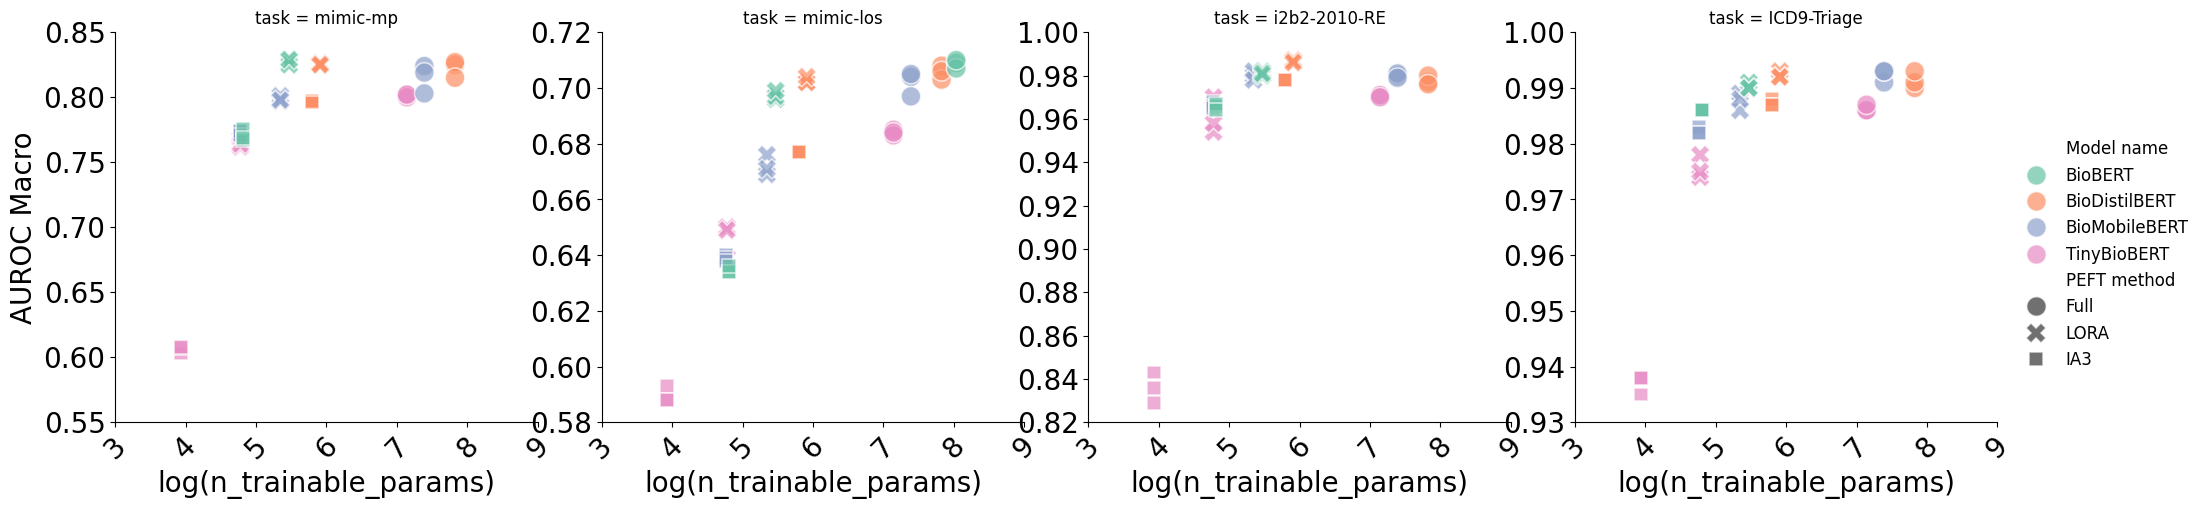

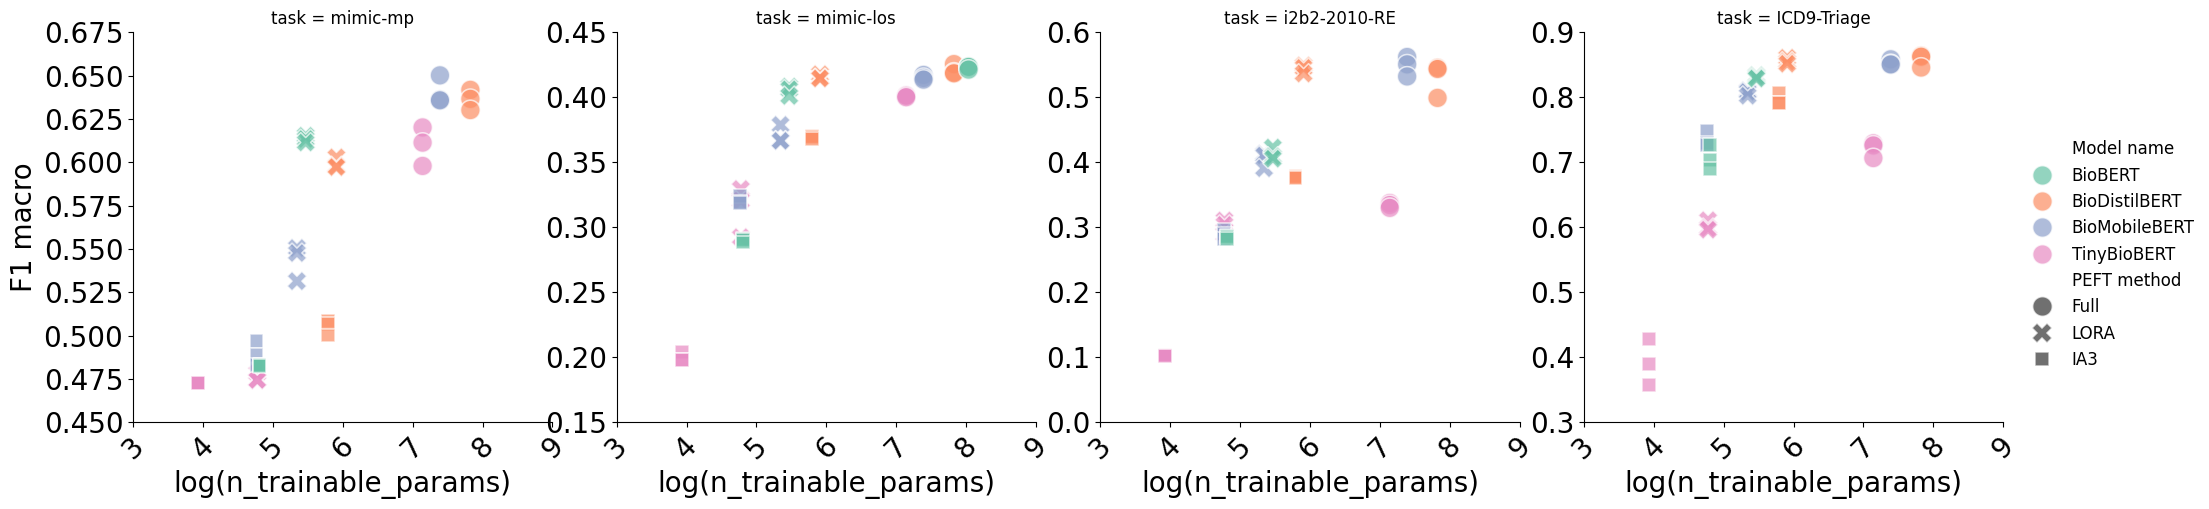

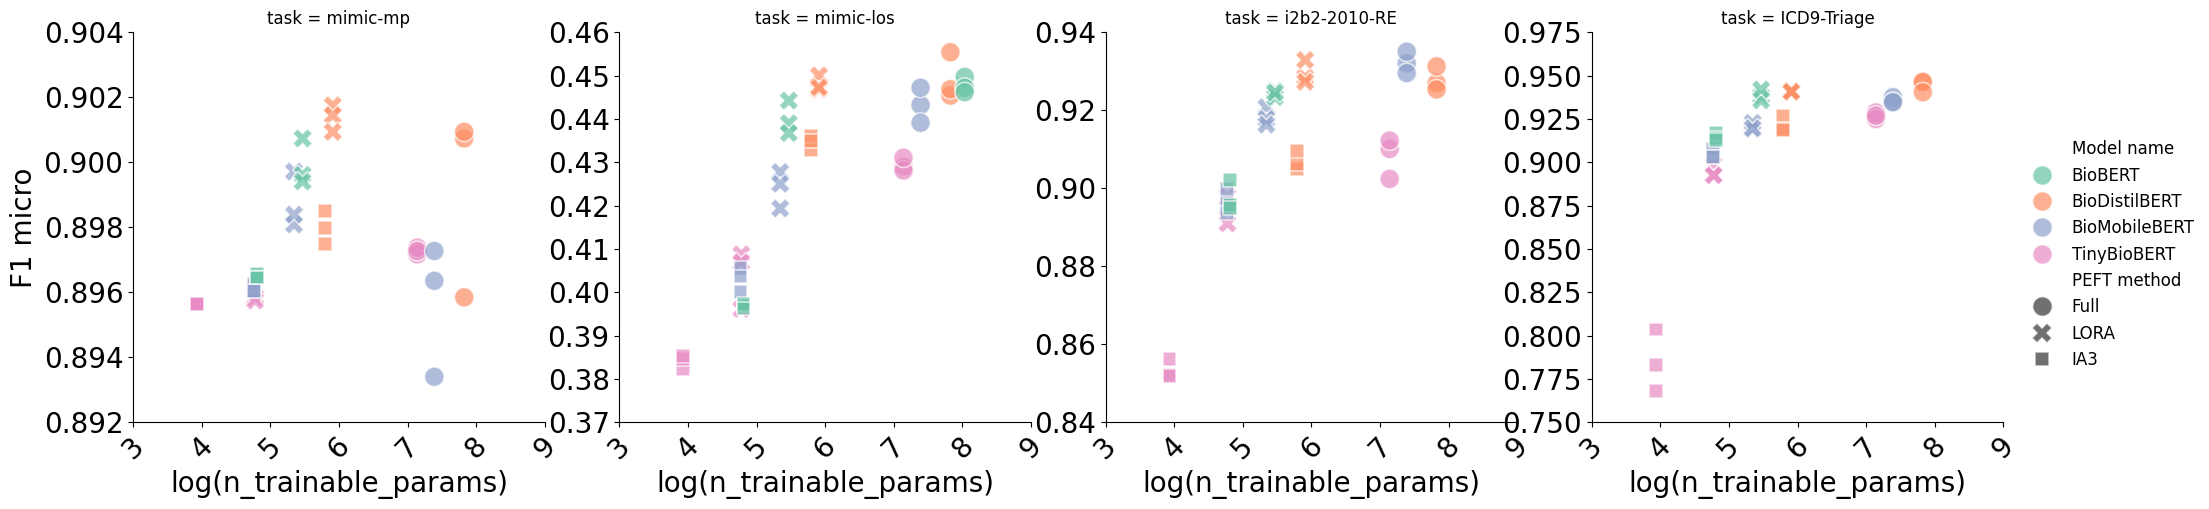

In [35]:
metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
# have a nicer metric name mapping


for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot,
                     x='log(n_trainable_params)',
                     y=metric, style='PEFT method', 
                     hue='Model name',
                     hue_order = ['BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT'],
                       palette='Set2', s=200, alpha=0.7,
                     style_order=PEFT_methods_to_plot[::-1],
                     )
                     
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='PEFT method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45, fontsize =20)
    fg.set_yticklabels(fontsize =20)
    fg.set_xlabels('log(n_trainable_params)', fontsize =20)
    fg.set_ylabels(metric_name_mapping[metric], fontsize =20)
    # set subplot titles
    # fg.set_titles(col_template="{col_name}", row_template="{row_name}", fontsize =30)


    # plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params_fg.png', bbox_inches='tight')
    plt.show()


In [49]:
task = "MIMIC MP"
# task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task'])[metric,"PEFT_params"].median().reset_index()
# task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg({"roc_auc_macro": ["median","std"],
                                                                                             
#                                                                                              "PEFT_params": "first"}).reset_index()


task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(roc_auc_macro=("roc_auc_macro", "median"), 
                  std=("roc_auc_macro", "std"), 
                  params=("PEFT_params", "first")).reset_index()

In [50]:
task_df


,Model name,PEFT method,task,roc_auc_macro,std,params
0,BioBERT,IA3,mimic-mp,0.769,0.004726,64512
1,BioBERT,LORA,mimic-mp,0.828,0.002082,294912
2,BioDistilBERT,Full,mimic-mp,0.825,0.006429,66953472
3,BioDistilBERT,IA3,mimic-mp,0.797,0.000577,622848
4,BioDistilBERT,LORA,mimic-mp,0.825,0.000577,811776
5,BioMobileBERT,Full,mimic-mp,0.819,0.010970,24581888
6,BioMobileBERT,IA3,mimic-mp,0.774,0.001732,58368
7,BioMobileBERT,LORA,mimic-mp,0.798,0.002082,221184
8,TinyBioBERT,Full,mimic-mp,0.802,0.001155,13874136
9,TinyBioBERT,IA3,mimic-mp,0.607,0.002646,8544


In [45]:
task_df.columns

MultiIndex([(   'Model name',       ''),
            (  'PEFT method',       ''),
            (         'task',       ''),
            ('roc_auc_macro', 'median'),
            ('roc_auc_macro',    'std'),
            (  'PEFT_params',  'first')],
           names=['tag', None])

In [68]:
pivot_df = plot_df.pivot_table(index=['Model name', 'PEFT method', 'task', 'few_shot_n'], 
                               values=metric,
                               aggfunc=[np.median, np.mean, np.std])

pivot_df.columns = ['_'.join(col) for col in pivot_df.columns.values] 
# Flatten MultiIndex columns names

pivot_df = pivot_df.reset_index()

In [69]:
pivot_df

,Model name,PEFT method,task,few_shot_n,median_roc_auc_macro,mean_roc_auc_macro,std_roc_auc_macro
0,BioMobileBERT,IA3,ICD9-Triage,16.0,0.5000,0.506333,0.033946
1,BioMobileBERT,IA3,i2b2-2010-RE,16.0,0.4995,0.499500,0.002121
2,BioMobileBERT,IA3,mimic-los,16.0,0.5000,0.495667,0.009292
3,BioMobileBERT,IA3,mimic-mp,16.0,0.5000,0.500000,0.000000
4,BioMobileBERT,LORA,ICD9-Triage,16.0,0.5080,0.509333,0.010066
5,BioMobileBERT,LORA,i2b2-2010-RE,16.0,0.5095,0.509500,0.013435
6,BioMobileBERT,LORA,mimic-los,16.0,0.5000,0.495000,0.013229
7,BioMobileBERT,LORA,mimic-mp,16.0,0.5000,0.500000,0.000000
8,TinyBioBERT,Full,ICD9-Triage,16.0,0.7170,0.717000,0.004243
9,TinyBioBERT,Full,i2b2-2010-RE,16.0,0.5600,0.560000,0.011314


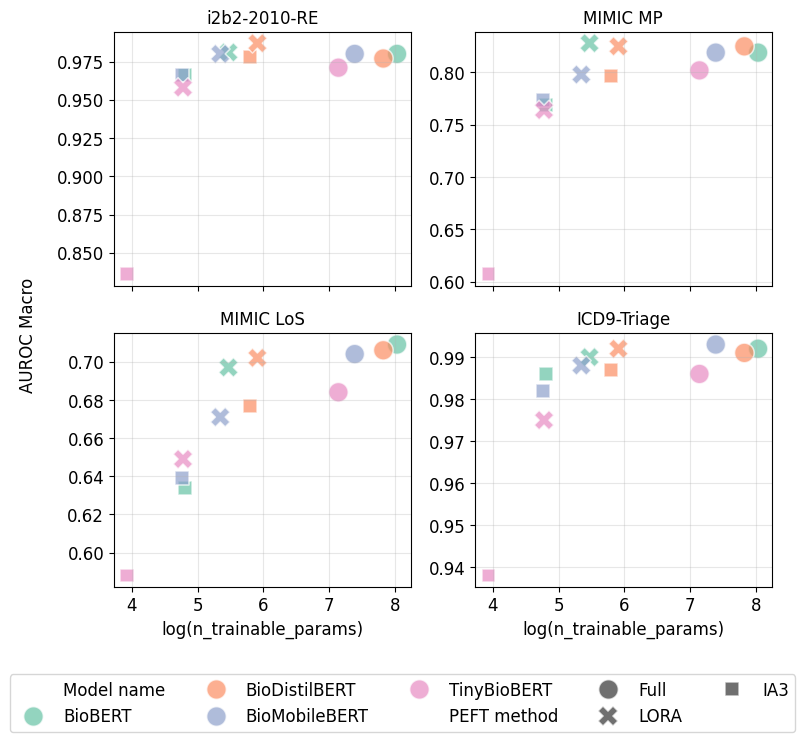

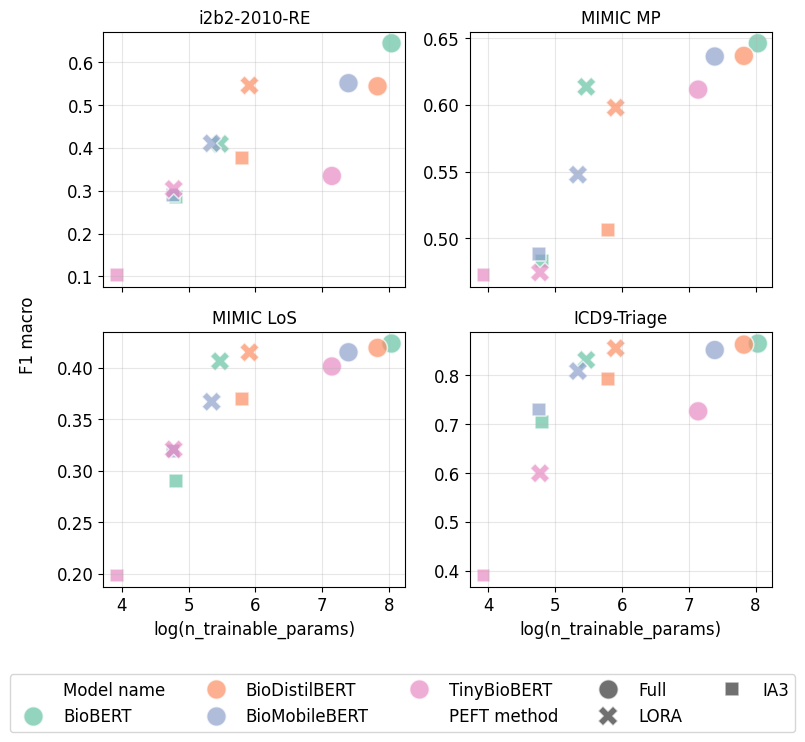

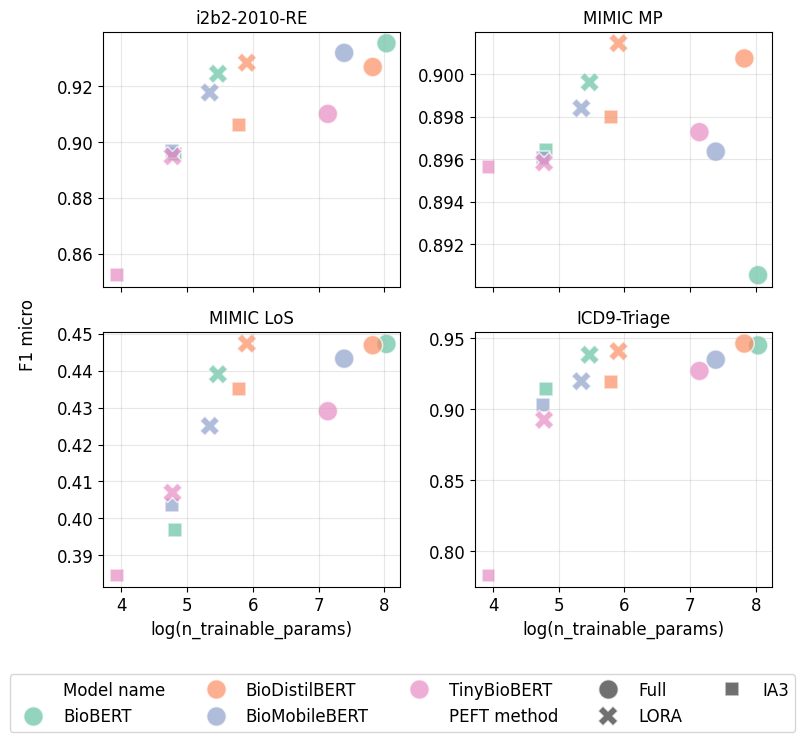

In [16]:
# for multiple runs - need to aggregate over random seed
metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
for metric in metrics:
    fig, ax = plt.subplots(2,2, figsize=(8,7), sharex=True, sharey=False)
    
    # loop over each task and plot on a different axis
    for i, task in enumerate(plot_df['task'].unique()):
        # subset to only the task we want and also find the median of the metric across each of the random seeds
        task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg({metric: "median",
                                                                                                     "PEFT_params": "first",
                                                                                                     "log(n_trainable_params)":"first"}).reset_index()
        # task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(metric=(metric, "median"), 
        #           std=(metric, "std"), 
        #           log_params=("log(n_trainable_params)", "first")).reset_index()
        # plot on the correct axis
        
        sns.scatterplot(data=task_df,
                        x='log(n_trainable_params)',
                        y=metric, style='PEFT method', 
                        hue='Model name',
                        hue_order = HUE_ORDER[:-1] , # we don't need llama which is last entry
                          palette= PALETTE,
                          s=200, 
                          alpha=0.7,
                        style_order=PEFT_methods_to_plot[::-1],
                        ax=ax.flatten()[i])
        # set grid with alpha of 0.5
        ax.flatten()[i].grid(alpha=0.3)
        
        ax.flatten()[i].set_title(task)
        ax.flatten()[i].set_xlabel('log(n_trainable_params)')
        # ax.flatten()[i].set_ylabel(metric_name_mapping[metric])
        ax.flatten()[i].set_ylabel('')
        # ax.flatten()[i].set_ylabel(metric_name_mapping[metric]) if i == 0 else ax.flatten()[i].set_ylabel('')
        
        # get legend handles
        handles, labels = ax.flatten()[i].get_legend_handles_labels()
        
        # remove legend
        ax.flatten()[i].get_legend().remove()
        # ax.flatten()[i].set_xticklabels(rotation = 45)
        # ax.flatten()[i].set_yticklabels(rotation = 45)
      # set legend
    # plt.ylabel(metric_name_mapping[metric])
    fig.add_subplot(111, frameon=False, )
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    # plt.ylabel(metric_name_mapping[metric], x=-0.9, ha='left')
    fig.text(x=0.02, y=0.5, s=metric_name_mapping[metric], 
         ha='left', va='center', rotation=90)
    
    
    fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.08))
    plt.tight_layout()
    plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params.png',
                bbox_inches='tight')

### Storage analysis

In [26]:
model_type_size_mappings

{'distil': {'LORA': {'full_model_size_GB': 0.49018238950520754,
   'full_model_size_MB': 501.9467668533325,
   'model_size_GB': 0.24506665021181107,
   'model_size_MB': 250.94824981689453,
   'n_trainable_params': 147456,
   'n_trainable_params_perc': 0.2241497999728751,
   'peft_full_model_size_GB': 0.24627410527318716,
   'peft_full_model_size_MB': 252.18468379974365,
   'peft_model_size_GB': 0.00054931640625,
   'peft_model_size_MB': 0.5625,
   'total_trainable_params': 65784578},
  'PREFIX_TUNING': {'full_model_size_GB': 0.49018238950520754,
   'full_model_size_MB': 501.9467668533325,
   'model_size_GB': 0.24506665021181107,
   'model_size_MB': 250.94824981689453,
   'n_trainable_params': 92160,
   'n_trainable_params_perc': 0.14009362498304695,
   'peft_full_model_size_GB': 0.24638669844716787,
   'peft_full_model_size_MB': 252.2999792098999,
   'peft_model_size_GB': 0.00034332275390625,
   'peft_model_size_MB': 0.3515625,
   'total_trainable_params': 65784578},
  'PROMPT_TUNING':

In [12]:
# do above for all keys
# then concat all together
# then merge with cls_results_df

# create list of dataframes
dfs = []
for key in model_type_size_mappings.keys():
    df = pd.DataFrame(model_type_size_mappings[key]).T.reset_index().rename(columns={"index":"peft_type"})
    df["model_type"] = key
    # append to list
    dfs.append(df)
    
# concat all together
model_type_size_df = pd.concat(dfs)

In [51]:
model_type_size_df

,peft_type,full_model_size_GB,full_model_size_MB,model_size_GB,model_size_MB,n_trainable_params,n_trainable_params_perc,peft_full_model_size_GB,peft_full_model_size_MB,peft_model_size_GB,peft_model_size_MB,total_trainable_params,model_type
0,LORA,0.490182,501.946767,0.245067,250.948250,147456.0,0.224150,0.246274,252.184684,0.000549,0.562500,6.578458e+07,distil
1,PREFIX_TUNING,0.490182,501.946767,0.245067,250.948250,92160.0,0.140094,0.246387,252.299979,0.000343,0.351562,6.578458e+07,distil
2,PROMPT_TUNING,0.490182,501.946767,0.245067,250.948250,10756.0,0.016350,0.245194,251.078483,0.000040,0.041031,6.578458e+07,distil
3,P_TUNING,0.490182,501.946767,0.245067,250.948250,221696.0,0.337003,0.247358,253.294841,0.000826,0.845703,6.578458e+07,distil
0,LORA,49.353743,50538.232680,24.614304,25205.046875,4194304.0,0.063479,24.770985,25365.488444,0.015625,16.000000,6.607352e+09,llama-7b
1,PREFIX_TUNING,49.353743,50538.232680,24.614304,25205.046875,2621440.0,0.039675,24.774753,25369.347331,0.009766,10.000000,6.607352e+09,llama-7b
2,PROMPT_TUNING,49.353743,50538.232680,24.614304,25205.046875,57344.0,0.000868,24.739845,25333.601352,0.000214,0.218750,6.607352e+09,llama-7b
3,P_TUNING,49.353743,50538.232680,24.614304,25205.046875,1110272.0,0.016804,24.763512,25357.835853,0.004136,4.235352,6.607352e+09,llama-7b
0,LORA,0.183584,187.989936,0.091578,93.776375,221184.0,0.899747,0.093835,96.086712,0.000824,0.843750,2.458291e+07,mobile
1,PREFIX_TUNING,0.183584,187.989936,0.091578,93.776375,245760.0,0.999719,0.094868,97.145123,0.000916,0.937500,2.458291e+07,mobile


/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

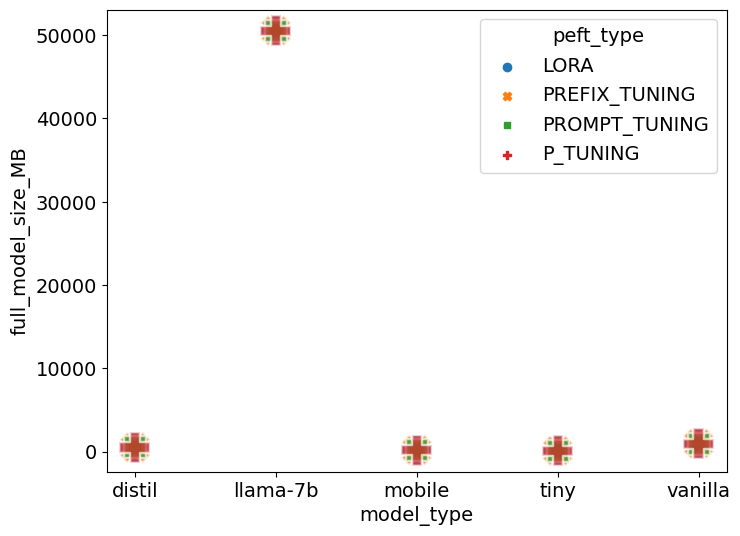

In [53]:
# plot the model type size df
# look at model type vs full model size
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data = model_type_size_df,
                     x = "model_type",
                     y = "full_model_size_MB",
                     hue = "peft_type",
                     style="peft_type",
                     s = 500,
                     alpha = 0.7,
                     
                     )


## Sensitivity analysis


### domain pre-training

In [9]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/' # original with single run for all models

dm_logs_df = read_tb_files(logs_dir)

  0%|          | 0/244 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--15-56/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--17-58/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--18-13/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base_declutr_2_anch_2_pos_min_1024/LORA/22-12-2023--18-14/config.yaml'


  0%|          | 0/149856 [00:00<?, ?it/s]

In [10]:
# get the SEQ_CLS results for dm
dm_cls_results_df = produce_results_table(dm_logs_df,
                                            metric = ["f1",
                                                        "accuracy",
                                                        "precision",
                                                        "recall",
                                                        "auc"],
                                            mode = "all",
                                            groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                            task_type = "SEQ_CLS",
                                            value_aggregate_method = "max",
                                            )

# same for NER
dm_ner_results_df = produce_results_table(dm_logs_df,
                                            metric = ["f1",
                                                        "accuracy",
                                                        "precision",
                                                        "recall",
                                                        "auc"],
                                            mode = "all",
                                            groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                            task_type = "TOKEN_CLS",
                                            value_aggregate_method = "max",
                                            )

# concat the two dataframes 

dm_results_df = pd.concat([dm_cls_results_df, dm_ner_results_df])

In [88]:
dm_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,eval/recall,eval/roc_auc_macro,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,eval/f1,f1
0,0,BERTbase,bert-base-uncased,ICD9-Triage,250.0,Full,0.944830,0.947013,0.876877,0.947013,...,0.886185,0.992056,0.872126,0.944830,0.945184,0.864495,0.881448,0.990813,NaN,NaN
1,1,BERTbase,bert-base-uncased,ICD9-Triage,250.0,LORA,0.912358,0.903019,0.631389,0.903019,...,0.650440,0.979965,0.632121,0.912358,0.899699,0.654783,0.655423,0.982676,NaN,NaN
2,2,BERTbase,bert-base-uncased,i2b2-2010-RE,250.0,Full,0.932000,0.930837,0.544309,0.930837,...,0.540983,0.981138,0.562515,0.932000,0.930019,0.588317,0.545287,0.975311,NaN,NaN
3,3,BERTbase,bert-base-uncased,i2b2-2010-RE,250.0,LORA,0.920419,0.917488,0.358018,0.917488,...,0.380196,0.978922,0.353060,0.920419,0.912713,0.372255,0.377330,0.979977,NaN,NaN
4,4,BERTbase,bert-base-uncased,mimic-los,250.0,Full,0.444583,0.430426,0.413175,0.430426,...,0.410729,0.691006,0.422577,0.444583,0.436728,0.433734,0.419396,0.702027,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,distil-biobert,nlpie/distil-biobert,i2b2-2012-NER,250.0,PREFIX_TUNING,0.763942,0.756912,NaN,NaN,...,0.418775,NaN,NaN,NaN,NaN,0.449556,0.422174,NaN,0.426700,0.435435
98,98,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,Full,0.995336,0.995452,NaN,NaN,...,0.955479,NaN,NaN,NaN,NaN,0.957572,0.953188,NaN,0.952837,0.955375
99,99,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,IA3,0.984981,0.985205,NaN,NaN,...,0.833733,NaN,NaN,NaN,NaN,0.852133,0.828818,NaN,0.841732,0.840314
100,100,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,LORA,0.991248,0.992098,NaN,NaN,...,0.910445,NaN,NaN,NaN,NaN,0.911723,0.901745,NaN,0.912711,0.906706


In [11]:
dm_PEFT_methods_to_plot = ["LORA","Full"]

In [12]:
dm_plot_df = dm_results_df.loc[dm_results_df['few_shot_n'] == 250].copy()
dm_plot_df =  dm_plot_df.loc[dm_plot_df['task'] != 'mednli']
# dm_plot_df = dm_plot_df.loc[dm_plot_df['Model name'].isin(
#     ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
dm_plot_df = dm_plot_df.loc[dm_plot_df['PEFT method'].isin(dm_PEFT_methods_to_plot)]
dm_plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
dm_plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
dm_plot_df['roc_auc_macro'] = dm_plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [91]:
dm_plot_df.query("`Model name` == 'RoBERTa-base'")

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,eval/recall,eval/roc_auc_macro,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,eval/f1,f1
90,90,RoBERTa-base,roberta-base,mimic-mp,250.0,LORA,0.900224,0.605469,0.532737,0.605469,...,0.605469,0.820007,0.600925,0.900224,0.874397,0.743701,0.574960,0.825,NaN,NaN
89,89,RoBERTa-base,roberta-base,mimic-mp,250.0,Full,0.894115,0.656250,0.619048,0.656250,...,0.656250,0.851135,0.635777,0.894115,0.878500,0.701446,0.609044,0.806,NaN,NaN


In [15]:
dm_plot_df["Model name"].unique()

array(['distil-biobert', 'TinyClinicalBERT', 'TinyBioBERT', 'TinyBERT',
       'RoBERTa-base', 'MobileBERT', 'Llama-2-7b', 'DistilBERTbase',
       'ClinicalMobileBERT', 'ClinicalDistilBERT', 'BioMobileBERT',
       'BioDistilBERT', 'BioClinicalBERT', 'BioBERT', 'BERTbase'],
      dtype=object)

In [13]:
# plotting order 
dm_peft_model_order = [
                        "TinyBioBERT", 
                        "TinyClinicalBERT",
                        "TinyBERT", 
                       "BioMobileBERT",
                       "ClinicalMobileBERT",
                       "MobileBERT",
                       "BioDistilBERT",
                       "ClinicalDistilBERT",
                       "DistilBERTbase",
                       "BERTbase",
                       "BioBERT",
                       "BioClinicalBERT",
                    #    "RoBERTa-base"
                       ]

# set mapping of domain pre-training to model name
dm_model_mapping = {"TinyBERT":"General",
                    "MobileBERT":"General",
                    "DistilBERTbase":"General",
                    "BioBERT":"Bio",
                    "TinyBioBERT":"Bio",
                    "BioMobileBERT":"Bio",
                    "BioDistilBERT":"Bio",
                    "BERTbase":"General",
                    # "RoBERTa-base":"General",
                    "BioClinicalBERT":"Clinical",
                    "TinyClinicalBERT":"Clinical",
                    "ClinicalMobileBERT":"Clinical",
                    "ClinicalDistilBERT":"Clinical"}

# set a model type mapping too for plotting
dm_model_type_mapping = {"TinyBERT":"Tiny",
                    "MobileBERT":"Mobile",
                    "DistilBERTbase":"Distil",
                    "BioBERT":"BERT",
                    "TinyBioBERT":"Tiny",
                    "BioMobileBERT":"Mobile",
                    "BioDistilBERT":"Distil",
                    "BERTbase":"BERT",
                    # "RoBERTa-base":"RoBERTa",
                    "TinyClinicalBERT":"Tiny",
                    "ClinicalMobileBERT":"Mobile",
                    "ClinicalDistilBERT":"Distil",
                    "BioClinicalBERT":"BERT"}

# add as new column
dm_plot_df["Domain pretraining"] = dm_plot_df["Model name"].map(dm_model_mapping)
# add type mapping too
dm_plot_df["Model type"] = dm_plot_df["Model name"].map(dm_model_type_mapping)

In [14]:
dm_plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,eval/f1,f1,Domain pretraining,Model type
100,100,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,LORA,0.991248,0.992098,NaN,NaN,...,NaN,NaN,NaN,0.911723,0.901745,NaN,0.912711,0.906706,NaN,NaN
96,96,distil-biobert,nlpie/distil-biobert,i2b2-2012-NER,250.0,LORA,0.864203,0.878370,NaN,NaN,...,NaN,NaN,NaN,0.682386,0.693115,NaN,0.720114,0.687709,NaN,NaN
135,135,distil-biobert,nlpie/distil-biobert,i2b2-2010-RE,250.0,LORA,0.906558,0.908465,0.328647,0.908465,...,0.328966,0.906558,0.900034,0.309850,0.361653,0.976,NaN,NaN,NaN,NaN
92,92,distil-biobert,nlpie/distil-biobert,i2b2-2010-NER,250.0,LORA,0.870465,0.892142,NaN,NaN,...,NaN,NaN,NaN,0.605742,0.572576,NaN,0.607275,0.588692,NaN,NaN
132,132,distil-biobert,nlpie/distil-biobert,MIMIC MP,250.0,LORA,0.898493,0.897922,0.535726,0.897922,...,0.526809,0.898493,0.858656,0.776498,0.527449,0.797,NaN,NaN,NaN,NaN


In [16]:
dm_plot_df.query("task == 'i2b2-2010-RE'")[["Model name", "Domain pretraining", "PEFT method", "eval/f1_macro", "eval/f1_micro", "eval/roc_auc_macro","f1_weighted"]]

tag,Model name,Domain pretraining,PEFT method,eval/f1_macro,eval/f1_micro,eval/roc_auc_macro,f1_weighted
135,distil-biobert,NaN,LORA,0.328647,0.908465,0.975334,0.900034
134,distil-biobert,NaN,Full,0.561167,0.928326,0.984173,0.927556
121,TinyClinicalBERT,Clinical,LORA,0.319277,0.901070,0.967912,0.894316
120,TinyClinicalBERT,Clinical,Full,0.339610,0.912326,0.971817,0.906660
113,TinyBioBERT,Bio,LORA,0.268724,0.887023,0.953217,0.869152
111,TinyBioBERT,Bio,Full,0.333454,0.907860,0.972151,0.903352
98,TinyBERT,General,LORA,0.147782,0.864791,0.905218,0.816214
97,TinyBERT,General,Full,0.237101,0.886884,0.921025,0.863091
88,MobileBERT,General,LORA,0.405351,0.911442,0.979771,0.905170
87,MobileBERT,General,Full,0.525380,0.927953,0.984873,0.925160


In [101]:
dm_plot_df.query("task == 'MIMIC LoS'")[["Model name", "Domain pretraining", "PEFT method", "eval/f1_macro", "eval/f1_micro", "eval/roc_auc_macro","f1_weighted"]]

tag,Model name,Domain pretraining,PEFT method,eval/f1_macro,eval/f1_micro,eval/roc_auc_macro,f1_weighted
130,distil-biobert,NaN,LORA,0.352438,0.406286,0.660010,0.407209
128,distil-biobert,NaN,Full,0.410929,0.429970,0.690352,0.434849
119,TinyClinicalBERT,NaN,LORA,0.330938,0.401275,0.653870,0.400425
118,TinyClinicalBERT,NaN,Full,0.384684,0.424732,0.683137,0.433733
108,TinyBioBERT,NaN,LORA,0.300728,0.387611,0.635998,0.365567
106,TinyBioBERT,NaN,Full,0.380408,0.421089,0.673502,0.418606
96,TinyBERT,NaN,LORA,0.204148,0.375313,0.588501,0.289188
95,TinyBERT,NaN,Full,0.384688,0.411296,0.665535,0.415505
86,MobileBERT,NaN,LORA,0.348924,0.406513,0.651268,0.395369
85,MobileBERT,NaN,Full,0.409864,0.439080,0.695632,0.435117


#### latex table

In [97]:
dm_plot_df.task.unique()

array(['mimic-mp', 'mimic-los', 'i2b2-2014-NER', 'i2b2-2012-NER',
       'i2b2-2010-RE', 'i2b2-2010-NER', 'ICD9-Triage'], dtype=object)

In [100]:
# produce latex table of all the dm results
dm_paper_results = dm_plot_df.groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])['roc_auc_macro'].max().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='roc_auc_macro').reset_index()
print(dm_paper_results.to_latex(
            caption = "PEFT results for CLS tasks dependent on domain pre-training received",
            label = "domain-peft-cls-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks dependent on domain pre-training received}
\label{domain-peft-cls-results}
\begin{tabular}{llrrrr}
\toprule
        Model name & PEFT method &  ICD9-Triage &  i2b2-2010-RE &  mimic-los &  mimic-mp \\
\midrule
          BERTbase &        Full &        0.991 &         0.975 &      0.702 &     0.799 \\
          BERTbase &        LORA &        0.983 &         0.980 &      0.679 &     0.811 \\
           BioBERT &        Full &        0.991 &         0.982 &      0.711 &     0.812 \\
           BioBERT &        LORA &        0.991 &         0.985 &      0.697 &     0.828 \\
   BioClinicalBERT &        Full &        0.993 &         0.978 &      0.697 &     0.793 \\
   BioClinicalBERT &        LORA &        0.990 &         0.981 &      0.701 &     0.822 \\
     BioDistilBERT &        Full &        0.992 &         0.979 &      0.697 &     0.803 \\
     BioDistilBERT &        LORA &        0.993 &         0.988 &      0.704 &   

/tmp/ipykernel_39157/2741877156.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dm_paper_results.to_latex(


In [101]:
dm_paper_results = dm_plot_df.groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])['f1'].max().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='f1').reset_index()
print(dm_paper_results.to_latex(
            caption = "PEFT results for CLS tasks dependent on domain pre-training received",
            label = "domain-peft-cls-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks dependent on domain pre-training received}
\label{domain-peft-cls-results}
\begin{tabular}{llrrr}
\toprule
        Model name & PEFT method &  i2b2-2010-NER &  i2b2-2012-NER &  i2b2-2014-NER \\
\midrule
          BERTbase &        Full &          0.806 &          0.792 &          0.974 \\
          BERTbase &        LORA &          0.673 &          0.697 &          0.951 \\
           BioBERT &        Full &          0.822 &          0.823 &          0.969 \\
           BioBERT &        LORA &          0.713 &          0.757 &          0.935 \\
   BioClinicalBERT &        Full &          0.846 &          0.820 &          0.960 \\
   BioClinicalBERT &        LORA &          0.704 &          0.746 &          0.920 \\
     BioDistilBERT &        Full &          0.809 &          0.794 &          0.965 \\
     BioDistilBERT &        LORA &          0.704 &          0.726 &          0.939 \\
     BioMobileBERT &        Full & 

/tmp/ipykernel_39157/67771776.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dm_paper_results.to_latex(


#### the task here may be quite important

MIMIC MP, MIMIC LoS, and ICD9 may be unfair as the clinical models have been trained on presumably all mimic notes

############## Task is : i2b2-2010-RE ##############


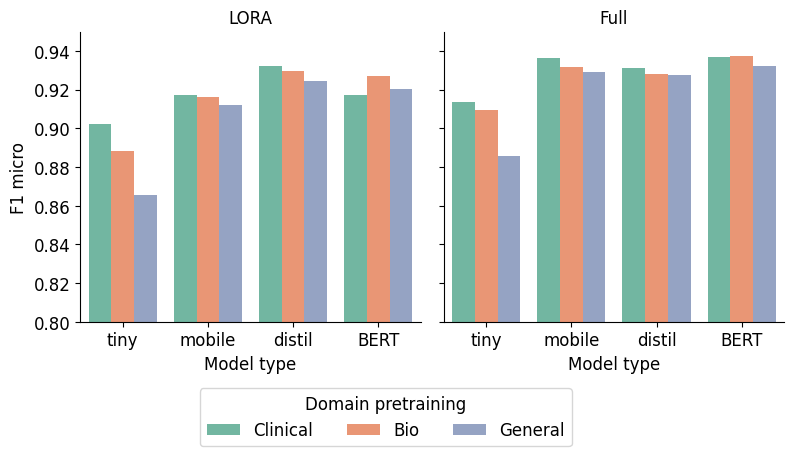

In [32]:
# metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted']
metrics = ['f1_micro']


# tasks = ["MIMIC LoS", "MIMIC MP", "ICD9-Triage", "i2b2-2010-RE"]
tasks = [ "i2b2-2010-RE"]

# loop over task
for task in tasks:
        print(f"############## task is : {task} ##############")
        for metric in metrics:
                # change font size
                

                # fig, ax = plt.subplots(figsize=(7,7))
                g = sns.FacetGrid(data = dm_plot_df.query("task == @task"),
                                col='PEFT method',
                                sharey=True, 
                                legend_out=True, 
                                aspect = 1, 
                                height = 4)
                g.map_dataframe(sns.barplot,
                                x = "Model type",
                                y = metric,
                                hue = "Domain pretraining",
                                palette='Set2',
                                )
                
                # change the column name of the facet grid from PEFT method to Peft method
                g.set_titles(col_template="{col_name}", row_template="{row_name}")
                
                
                # add y limit to facegrid plot
                g.set(ylim=(0.8, 0.95))
                
                plt.legend(
                        title = "Domain pretraining",
                        loc='upper right', 
                        bbox_to_anchor=(0.4, -0.2),  
                        fancybox=True, shadow=False, 
                        ncol=5
                        )

                # replace y axis with metric name
                g.set_ylabels(metric_name_mapping[metric])

                # plt.suptitle("PEFT Method", x=0.5, y=0, ha='center')
                # plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
                # save
                # plt.tight_layout()
                plt.savefig(f'{save_path}/{task}_{metric}_PEFT methods_dm.png', bbox_inches='tight')
                plt.show()

############## task is : MIMIC LoS ##############


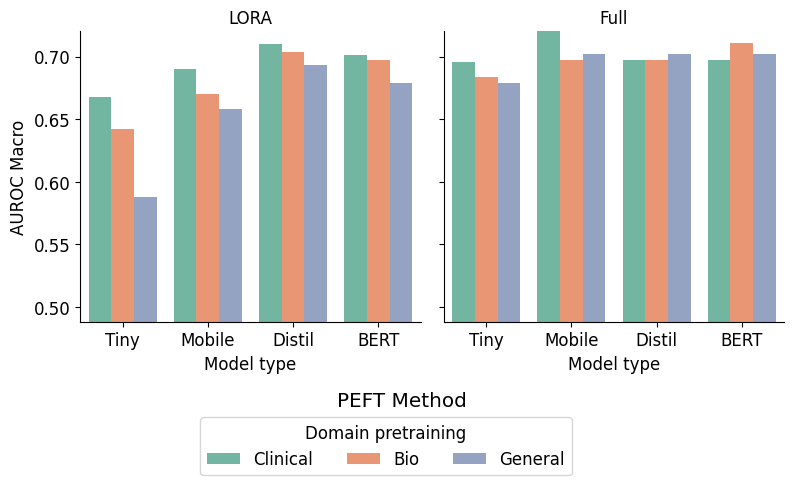

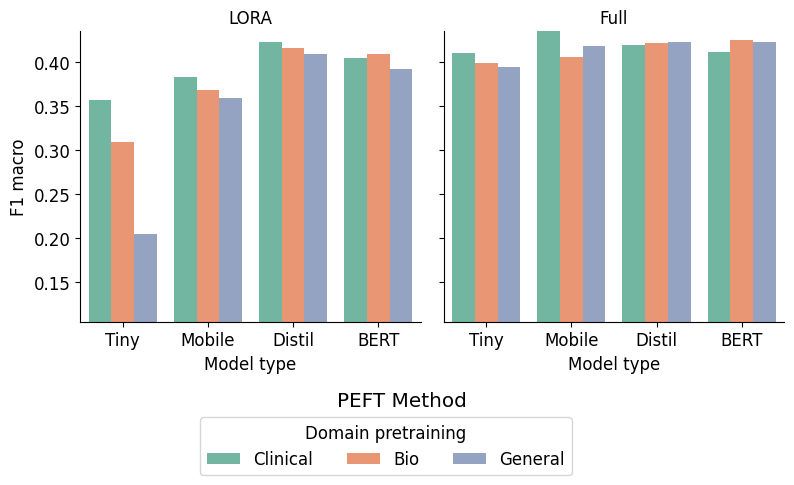

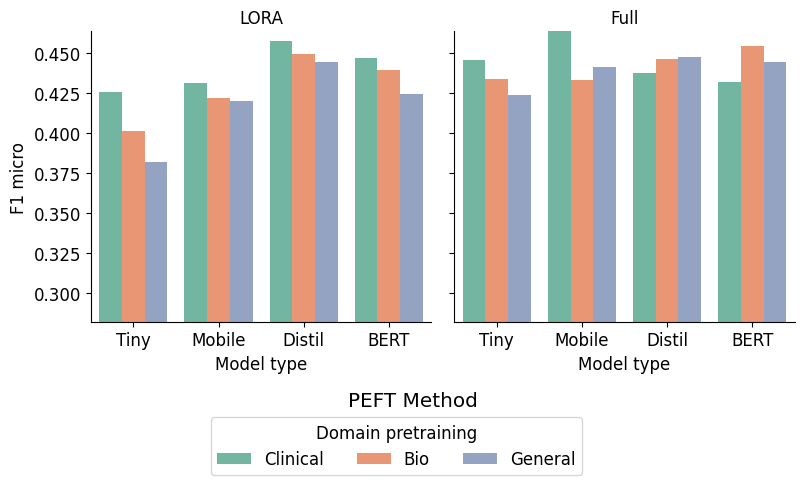

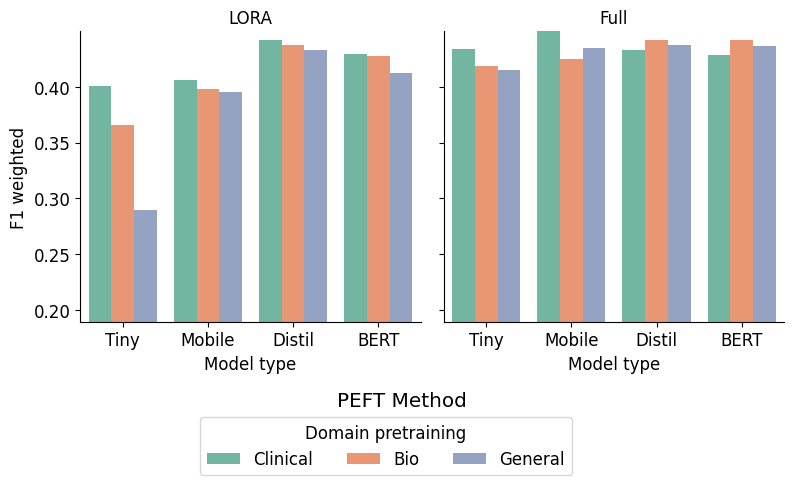

############## task is : MIMIC MP ##############


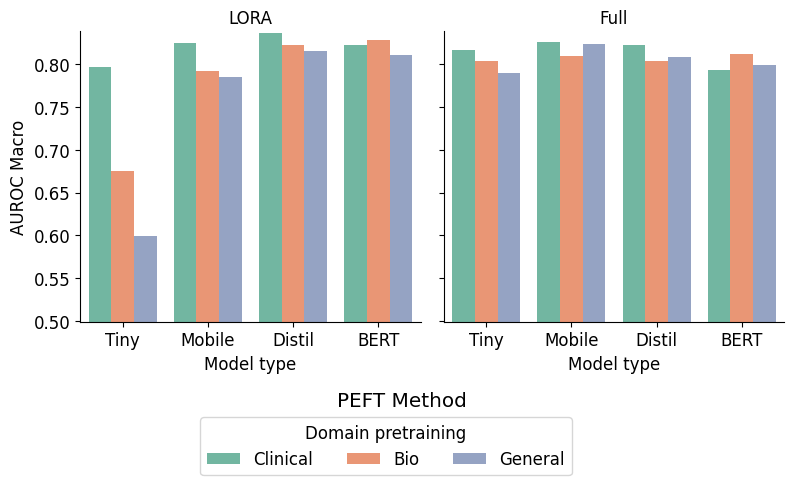

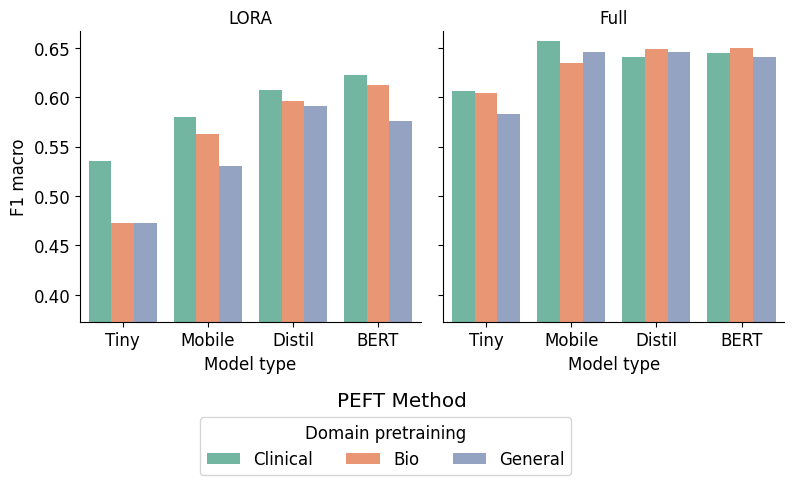

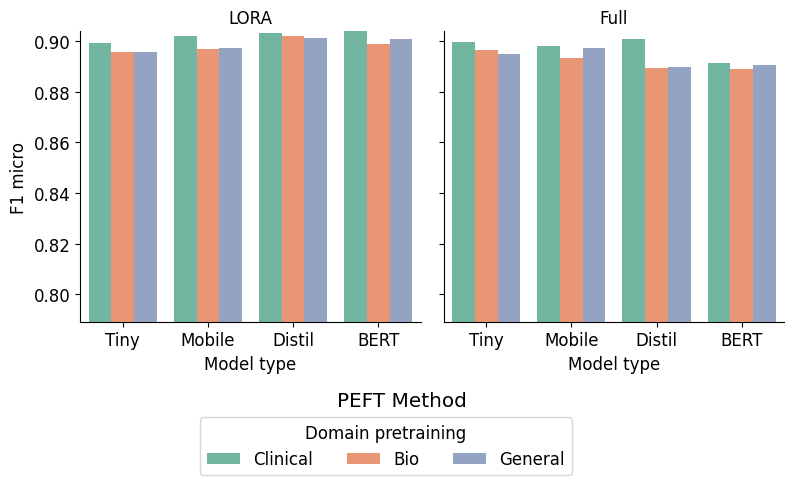

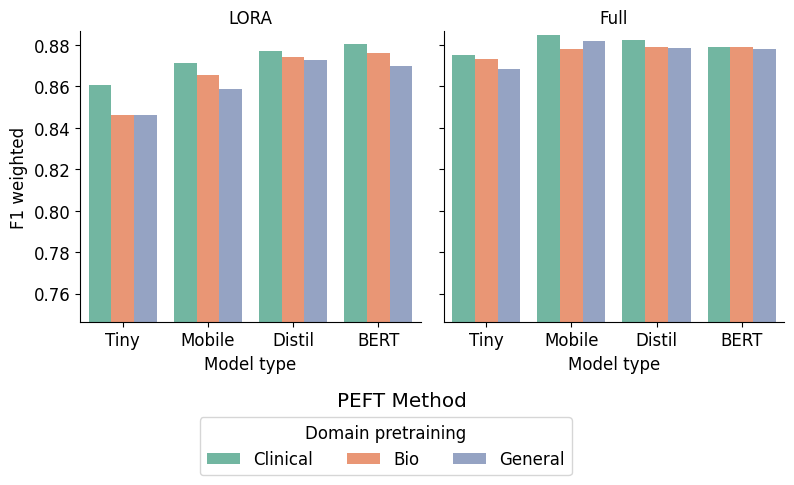

############## task is : ICD9-Triage ##############


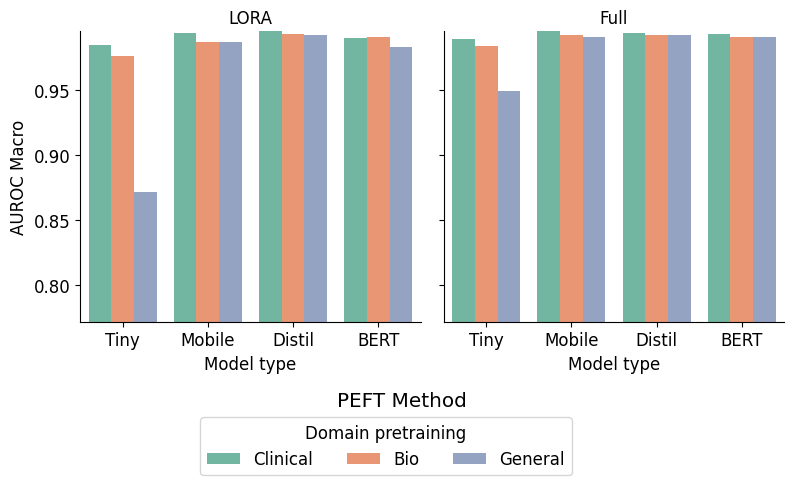

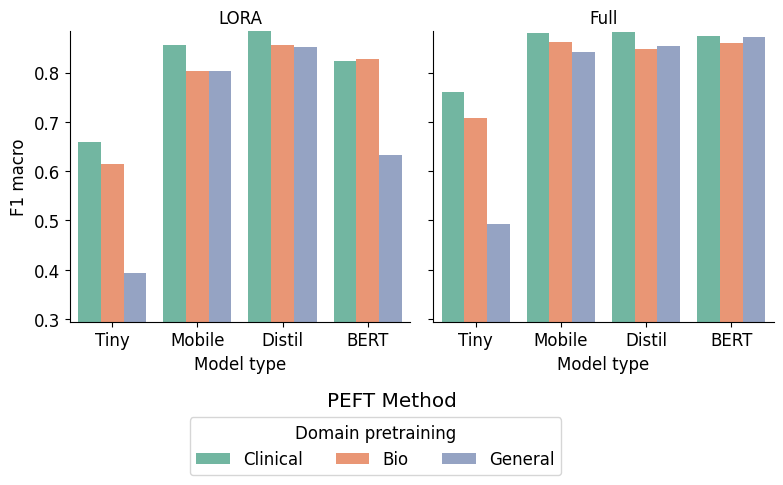

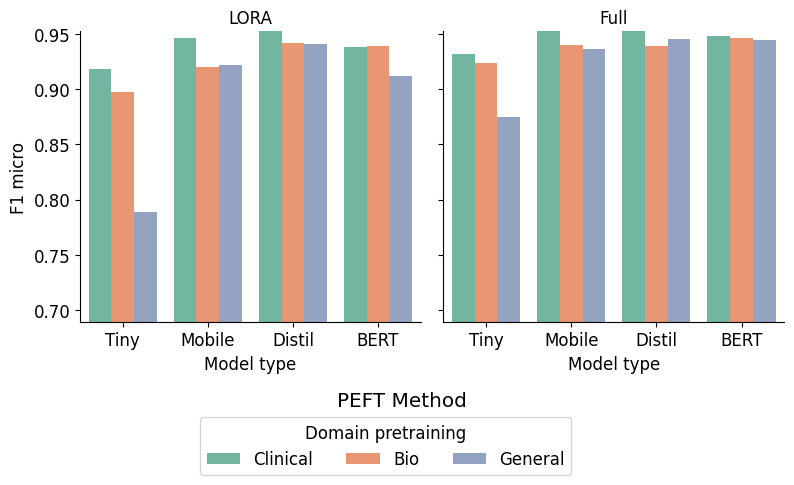

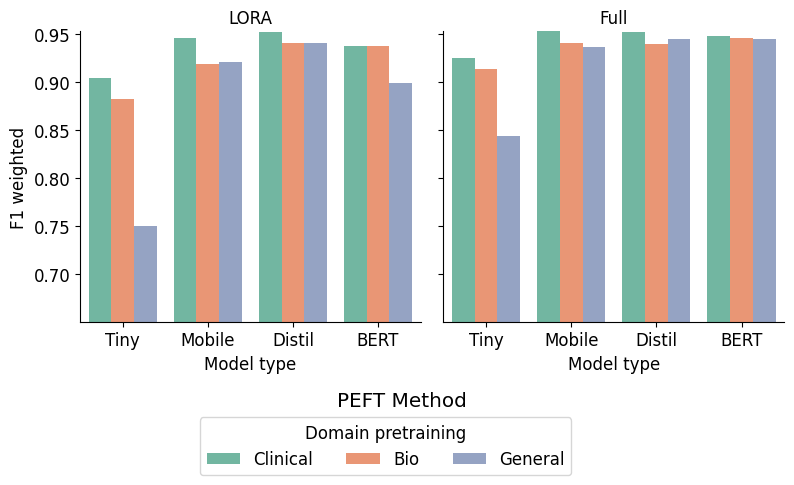

############## task is : i2b2-2010-RE ##############


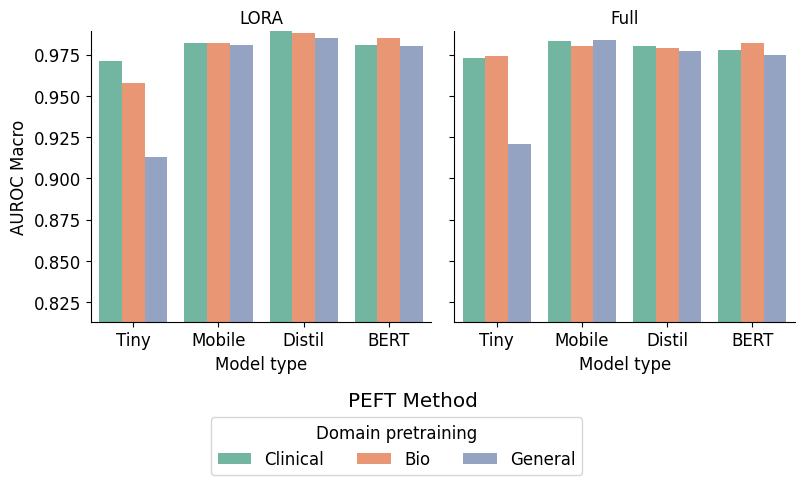

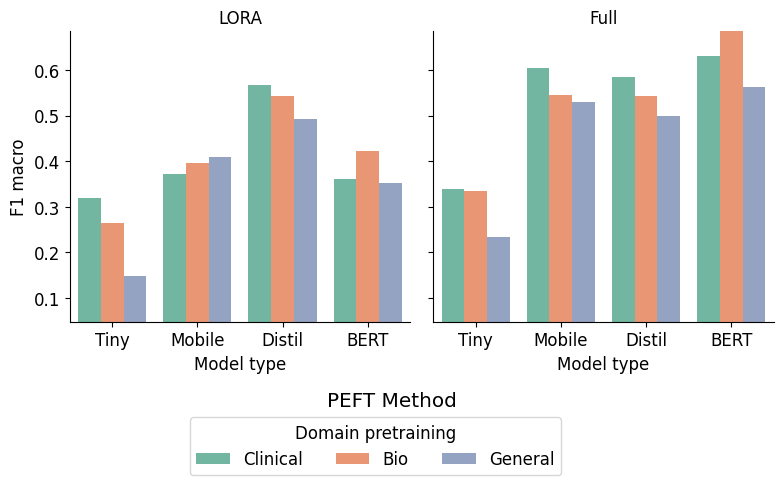

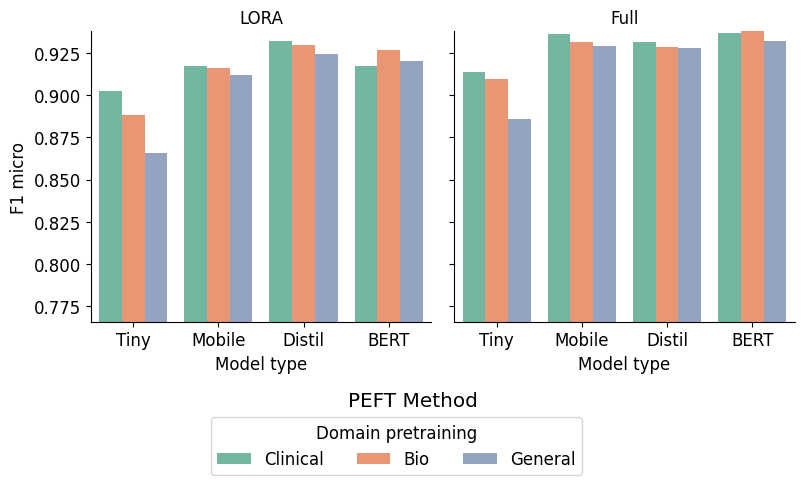

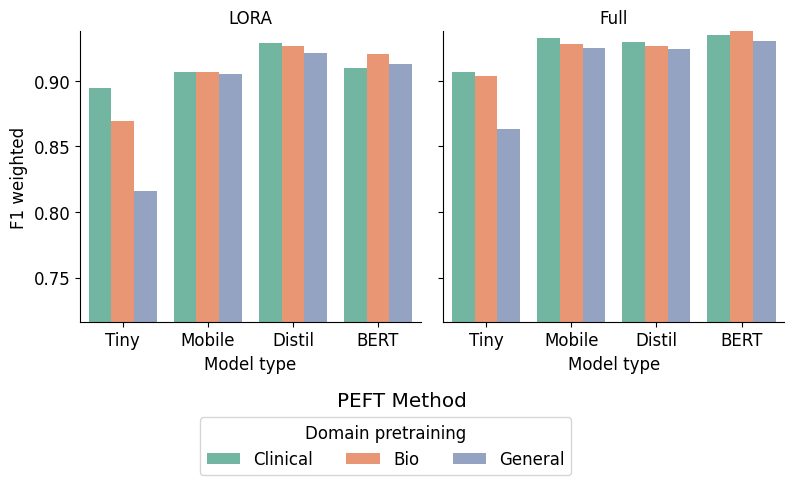

In [18]:
metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted']
# metrics = ['f1_micro']


tasks = ["MIMIC LoS", "MIMIC MP", "ICD9-Triage", "i2b2-2010-RE"]
# tasks = [ "i2b2-2010-RE"]

# loop over task
for task in tasks:
        print(f"############## task is : {task} ##############")
        for metric in metrics:
                # change font size
                

                # fig, ax = plt.subplots(figsize=(7,7))
                g = sns.FacetGrid(data = dm_plot_df.query("task == @task"),
                                col='PEFT method',
                                sharey=True, 
                                legend_out=True, 
                                aspect = 1, 
                                height = 4)
                g.map_dataframe(sns.barplot,
                                x = "Model type",
                                y = metric,
                                hue = "Domain pretraining",
                                palette='Set2',
                                )
                
                # change the column name of the facet grid from PEFT method to Peft method
                g.set_titles(col_template="{col_name}", row_template="{row_name}")
                
                
                # add y limit to facegrid plot
                # set the y limit dynamically based on the min and max?
                y_min = dm_plot_df.query("task == @task")[metric].min()
                y_max = dm_plot_df.query("task == @task")[metric].max()
                g.set(ylim=(y_min-0.1, y_max))
                # g.set(ylim=(0.8, 0.95))
                
                plt.legend(
                        title = "Domain pretraining",
                        loc='upper right', 
                        bbox_to_anchor=(0.4, -0.3),  
                        fancybox=True, shadow=False, 
                        ncol=5
                        )

                # replace y axis with metric name
                g.set_ylabels(metric_name_mapping[metric])

                plt.suptitle("PEFT Method", x=0.5, y=0, ha='center')
                # plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
                # save
                plt.savefig(f'{save_path}/{task}_{metric}_peft_methods_dm.png', bbox_inches='tight')
                plt.show()

### Fewshot sampling vs performance

In [17]:
# the dir needs the trailing slash 
# fs_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/fewshot_budget_linearLR/logs/"
fs_logs_dir = "/mnt/sdh/effecient_ml/fewshot_budget/logs/"

In [18]:
# load in the few shot sensitivity 
fs_logs_df = read_tb_files(fs_logs_dir)

# cls_results_df = produce_results_table(logs_df, 
#                                 metric = ["f1",
#                                         "accuracy",
#                                         "precision",
#                                         "recall",
#                                         "auc", 
#                                         "train/total_flos", "train/train_loss",
#                                         "train/train_runtime", "train/train_samples_per_second",
#                                         "train/train_steps_per_second"],
#                                 mode = "all",
#                                 groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
#                                 task_type = "SEQ_CLS",
#                                 value_aggregate_method = "max",
#                                 )

# do same for fs_logs_df

fs_cls_results_df = produce_results_table(fs_logs_df,
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

  0%|          | 0/93 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdh/effecient_ml/fewshot_budget/logs/mimic-mp/fewshot_4096/Llama-2-7b-hf/PROMPT_TUNING/15-02-2024--13-52/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdh/effecient_ml/fewshot_budget/logs/mimic-mp/fewshot_4096/Llama-2-7b-hf/PROMPT_TUNING/16-02-2024--08-37/config.yaml'


  0%|          | 0/14001 [00:00<?, ?it/s]

In [22]:
fs_cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,16,Full,0.514254,0.542969,0.542906,0.542969,...,0.514254,0.604579,0.512562,0.533600,0.532807,4.735999e+13,0.616700,40.445599,7.912,0.247
1,1,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,16,LORA,0.553044,0.546875,0.545877,0.546875,...,0.553044,0.639203,0.508196,0.521639,0.520717,7.947832e+13,0.680826,47.839199,6.689,0.209
2,2,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,32,Full,0.507941,0.535156,0.534581,0.535156,...,0.507941,0.598894,0.511245,0.530076,0.539727,1.105066e+14,0.674736,50.742500,12.613,0.394
3,3,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,32,LORA,0.384952,0.527344,0.511512,0.527344,...,0.384952,0.471395,0.508643,0.520890,0.525758,1.589566e+14,0.710534,52.774601,12.127,0.379
4,4,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,64,Full,0.599369,0.574219,0.572752,0.574219,...,0.599369,0.677201,0.526088,0.567325,0.593590,3.157333e+14,0.535528,84.508202,15.146,0.473


In [23]:
fs_cls_results_df.few_shot_n.unique()

array([  16,   32,   64,  128,  256,  512, 1024, 2048, 4096])

In [34]:
fs_cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype='object', name='tag')

In [35]:
fs_cls_results_df.query("few_shot_n == 4096")[["Model name", "task", "few_shot_n", "PEFT method", "eval/roc_auc_macro", "train/train_runtime"]]

tag,Model name,task,few_shot_n,peft_method,eval/roc_auc_macro,train/train_runtime
16,BioBERT,mimic-mp,4096,Full,0.798677,2025.520508
17,BioBERT,mimic-mp,4096,LORA,0.804639,1547.642700
18,Llama-2-7b,mimic-mp,4096,LORA,0.826167,28254.244141
35,RoBERTa-base,mimic-mp,4096,Full,0.797783,1599.247559
36,RoBERTa-base,mimic-mp,4096,LORA,0.802199,1377.530518
53,bio-mobilebert,mimic-mp,4096,Full,0.803967,989.753906
54,bio-mobilebert,mimic-mp,4096,LORA,0.791002,1051.067993
71,distil-biobert,mimic-mp,4096,Full,0.793782,976.901672
72,distil-biobert,mimic-mp,4096,LORA,0.798827,908.158691
89,tiny-biobert,mimic-mp,4096,Full,0.785742,419.180511


In [18]:
fs_cls_results_df["Model name"].unique()

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'RoBERTa-base',
       'TinyBioBERT'], dtype=object)

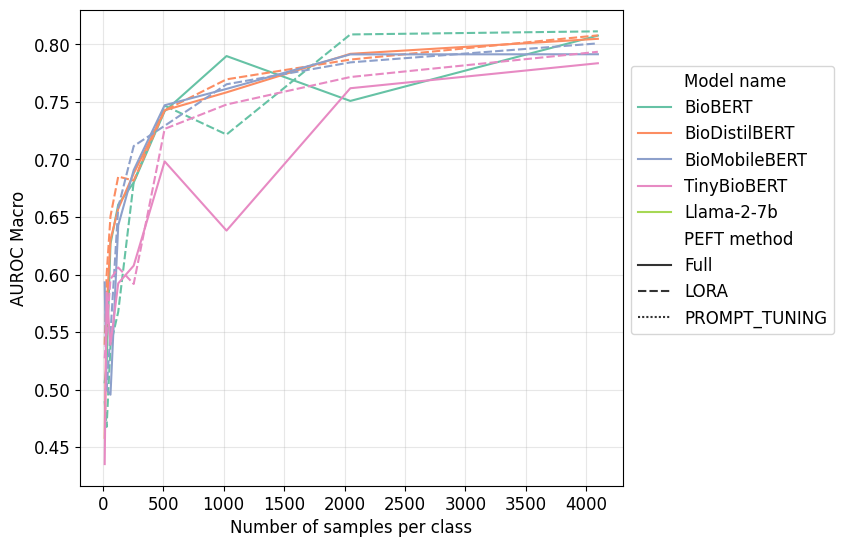

In [19]:
task = "MIMIC MP"

fig, ax = plt.subplots(figsize=(7,7))
metric = "roc_auc_macro" # | roc_auc_macro
# lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.lineplot(data = fs_cls_results_df.query("task == @task & `Model name` != 'RoBERTa-base'"),
             x = "few_shot_n",
             y = metric,
             hue = "Model name",
            hue_order = HUE_ORDER,
             style = "PEFT method",
             ax = ax,
             legend = True,
             palette = PALETTE
             )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
plt.legend(loc=2, # 'upper right',
           bbox_to_anchor=(1., 0.9),  
           fancybox=True, shadow=False, 
           ncol=1)
# set grid with alpha 0.3
ax.grid(alpha=0.3)

# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above
# ax.axhline(y=cls_results_df.query("`Model name` == 'BioBERT' & task == @task & few_shot_n == 250")["roc_auc_macro"].values[0], color='black', linestyle='--', alpha = 0.5)
# remove x axis label
ax.set_xlabel("Number of samples per class")

# fig.suptitle("Number of samples per class", x=0.5, y=0.1, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)

# save
plt.savefig(f'{save_path}/{task}_few_shot_n_sensitivity.png', bbox_inches='tight')

In [65]:
save_path

'/mnt/sdd/efficient_ml_data/figures_and_plots/'

<Figure size 700x700 with 0 Axes>

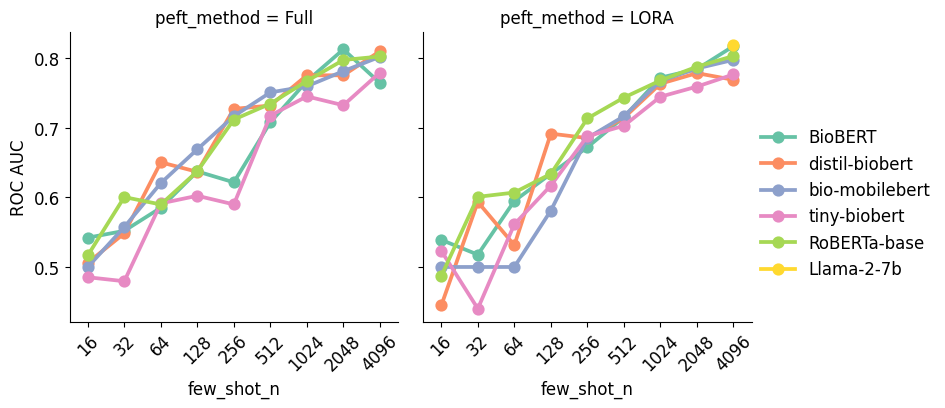

<Figure size 700x700 with 0 Axes>

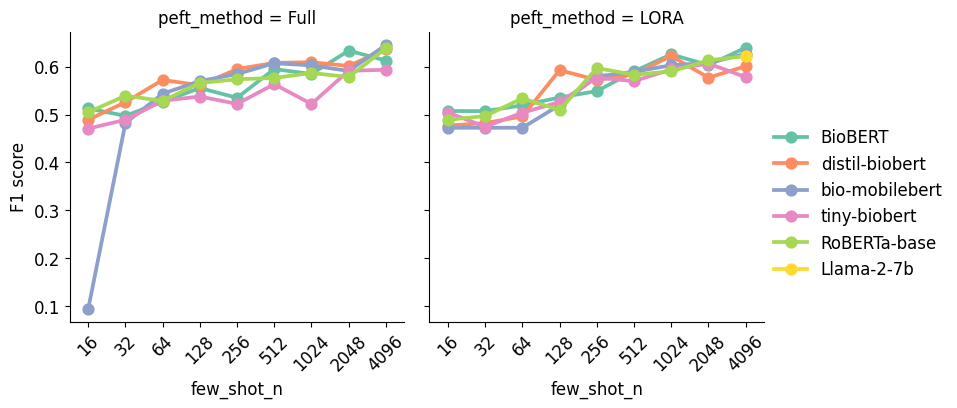

In [30]:
# same as above but with facet

metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:

    plt.figure(figsize=(7, 7))
    fg = sns.FacetGrid(data=fs_cls_results_df,
                        col='PEFT method', 
                        sharey=True,
                          sharex=True,
                            legend_out=True,
                              aspect = 1, 
                              height = 4,
                              )
    fg.map_dataframe(sns.pointplot,
                      x='few_shot_n',
                        y=metric,
                          hue='Model name', 
                      hue_order = [
                                'BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT',
                                  'Llama-2-7b',
                                  # 'RoBERTa-base'
                                  ],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # set y label based on metric mapping
    fg.set_ylabels(metric_name_mapping[metric])
    
    # add grid lines
    # fg.grid()
    # save
    # plt.savefig(f'{save_path}/{metric}_few_shot_n_sensitivity_facet.png', bbox_inches='tight')
    plt.show()

In [113]:
metric_name_mapping

{'f1_macro': 'F1 macro',
 'f1_micro': 'F1 micro',
 'f1': 'F1',
 'f1_weighted': 'F1 weighted',
 'roc_auc_macro': 'AUROC Macro'}

/tmp/ipykernel_12593/372582581.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
/tmp/ipykernel_12593/372582581.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.rename(columns={'few_shot_n': 'Num training samples',


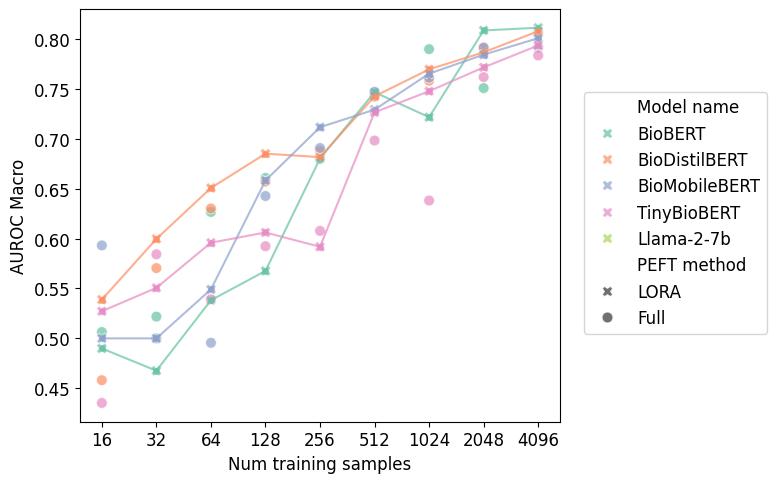

In [16]:

plot_df = fs_cls_results_df.loc[fs_cls_results_df['Model name'] != 'RoBERTa-base']
# convert few_shot_n to string
plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
plot_df.rename(columns={'few_shot_n': 'Num training samples', 
                        'roc_auc_macro':metric_name_mapping['roc_auc_macro'],
                        'peft_method': 'PEFT method'}, inplace=True)
metrics = ['AUROC Macro']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.pointplot(data=plot_df.loc[plot_df['PEFT method'] == 'LORA'], 
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = ['BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT',
                                  'Llama-2-7b',
                                #   'RoBERTa-base',
                                  ],
                  alpha=0.7, linewidth=1.5, markersize=4, palette=PALETTE, legend=False)
    sns.scatterplot(data=plot_df, 
                  x='Num training samples', y=metric, 
                  hue='Model name',
                  hue_order = HUE_ORDER,
                  style='PEFT method', style_order=[ 'LORA', 'Full'],
                  alpha=0.7, markers=['X', 'o'], s=60, palette=PALETTE)
    
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'{save_path}/fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.show()

### Few shot multiseed

In [11]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/fewshot_budget_multiseed/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))

fs_logs_df = fs_logs_df.loc[fs_logs_df['Model name'].isin(
    ['Llama-2-7b', 'BioBERT', 'BioMobileBERT', 'BioDistilBERT', 'TinyBioBERT'])]

fs_logs_df.loc[fs_logs_df['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'

fs_logs_df.shape

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/37968 [00:00<?, ?it/s]

(37968, 64)

In [24]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'random_seed', 'remove_columns',
       'save_adapter', 'save_every_steps', 'saving_strategy', 'scheduler_type',
       'task', 'task_to_keys', 'task_type', 'test_file', 'text_col',
       'text_column

In [9]:
fs_logs_df["Model name"].unique()

array(['BioDistilBERT', 'BioMobileBERT', 'BioBERT', 'TinyBioBERT',
       'Llama-2-7b'], dtype=object)

In [13]:
fs_cls_results_df = produce_results_table(fs_logs_df,
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task", "few_shot_n", "PEFT method", "random_seed"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

In [28]:
fs_cls_results_df["PEFT method"].unique()

array(['Full', 'LORA'], dtype=object)

In [29]:
HUE_ORDER

['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'TinyBioBERT', 'Llama-2-7b']

In [16]:
fs_cls_results_df["Model name"].unique()

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'Llama-2-7b',
       'TinyBioBERT'], dtype=object)

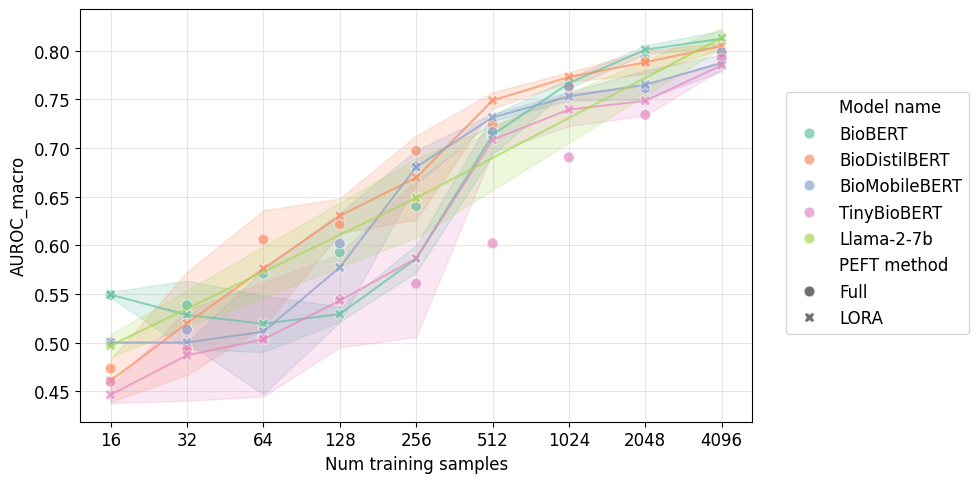

In [37]:
# same as above but with facet
# plot_df = fs_cls_results_df.loc[fs_cls_results_df['Model name'] != 'Llama-2-7b'].copy()
plot_df = fs_cls_results_df.copy()
plot_df['Model name'] = plot_df['Model name'].replace(MODEL_NAME_MAP)
plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(int).astype(str)
plot_df.rename(columns={'few_shot_n': 'Num training samples', 
                        'roc_auc_macro':'AUROC_macro',
                        'peft_method': 'PEFT method'}, inplace=True)
metrics = ['AUROC_macro']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=plot_df.loc[plot_df['PEFT method'] == 'LORA'], 
                  x='Num training samples', y=metric, errorbar='sd',
                  hue='Model name', hue_order = HUE_ORDER,
                  alpha=0.7, linewidth=1.5, palette=PALETTE, legend=False)
    sns.scatterplot(data=plot_df.groupby(['Model name', 'Num training samples', 'PEFT method'])[metric].mean().reset_index(),
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = HUE_ORDER,
                  style='PEFT method', style_order=['Full', 'LORA'],
                  alpha=0.7, markers=['o','X',], s=60, palette=PALETTE)
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
    plt.tight_layout()
    # add grid
    ax.grid(alpha=0.3)
    plt.savefig(f'{save_path}/fewshot_sensitivity_multiseed.png', bbox_inches='tight', dpi=300)
    # plt.savefig(f'fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.show()

In [33]:
plot_df["Model name"].unique()

array(['BioBERT', 'Llama-2-7b'], dtype=object)

### Time budget

In [7]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df = fs_logs_df.loc[fs_logs_df['Model name'].isin(
    [       
            'BioBERT',
            # 'distil-biobert',
            'BioDistilBERT',
            'BioMobileBERT',
            'TinyBioBERT',
            'Llama-2-7b'
            ])]
# fs_logs_df.loc[fs_logs_df['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'
fs_logs_df = fs_logs_df.loc[(fs_logs_df['scheduler_type'] == 'linear') | 
                            (fs_logs_df['Model name'] == 'Llama-2-7b')]

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))
fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
    ['Model name', 'PEFT method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]

fs_logs_df.shape

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/48339 [00:00<?, ?it/s]

(17958, 63)

In [23]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'remove_columns', 'save_adapter',
       'save_every_steps', 'saving_strategy', 'scheduler_type', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget

In [28]:
# from datetime import datetime
# def extract_datetime(x):
#     dt = x.split('/')[-1]
#     dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
#     return dt

# # load in the few shot sensitivity logs
# fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/logs/'
# fs_logs_df = read_tb_files(fs_logs_dir)
# fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))

# fs_logs_df.shape


# llama_logs = fs_logs_df.loc[fs_logs_df['Model name'] == 'Llama-2-7b']
# fs_logs_df = fs_logs_df.loc[fs_logs_df['scheduler_type'] == 'linear']
# fs_logs_df = pd.concat((fs_logs_df, llama_logs))

# # Group by model name and peft method and keep all rows with only the
# # latest datetime
# fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
#     ['Model name', 'PEFT method'])['datetime'].transform(
#         lambda x: x == x.max()).reindex()]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/48339 [00:00<?, ?it/s]

(48339, 63)

In [60]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'peft_method',
       'pretrained_models_dir', 'remove_columns', 'save_adapter',
       'save_every_steps', 'saving_strategy', 'scheduler_type', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget

In [15]:
fs_logs_df["Model name"].unique()

array(['Llama-2-7b', 'BioDistilBERT', 'BioMobileBERT', 'BioBERT',
       'TinyBioBERT'], dtype=object)

In [16]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'remove_columns', 'save_adapter',
       'save_every_steps', 'saving_strategy', 'scheduler_type', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget

In [118]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'remove_columns', 'save_adapter',
       'save_every_steps', 'saving_strategy', 'scheduler_type', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget

In [20]:
plot_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'PEFT method']].query("`Model name` != 'RoBERTa-base'")

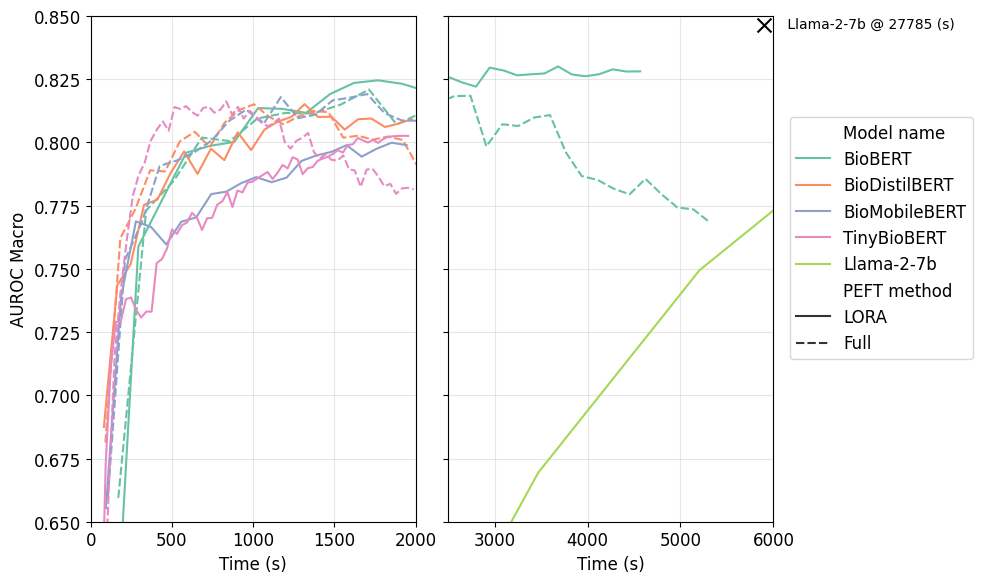

In [23]:

plot_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'PEFT method']].query("`Model name` != 'RoBERTa-base'")
plot_df['Time (s)'] = plot_df.groupby(['Model name', 'PEFT method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
plot_df = plot_df.loc[plot_df['tag'].str.contains('eval/roc_auc') ]
plot_df.rename(columns={'value': 'AUROC_macro'}, inplace=True)
# fg = sns.FacetGrid(data=plot_df, col='PEFT method', sharey=True, sharex=True, 
#                    legend_out=True, aspect = 1, height = 4, 
#                    col_order=['Full', 'LORA'])
# fg.map_dataframe(sns.lineplot, x='rel_time', y='value', hue='Model name', 
#                  hue_order=plot_df['Model name'].unique(), palette='Set2')
# fg.add_legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=False)
# ax = ax.flatten()
for ax_num, xrange in enumerate([(0, 2000), (2500, 6000)]):
    sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
                hue='Model name', 
                # hue_order=plot_df['Model name'].unique(), 
                hue_order = HUE_ORDER,
                style='PEFT method', style_order=['LORA','Full' ], 
                palette=PALETTE, ax=ax[ax_num], legend=ax_num==len(ax)-1)
    ax[ax_num].set_xlim(xrange)
    ax[ax_num].set_ylim((0.65, 0.85))
    # add grid
    ax[ax_num].grid(alpha=0.3)
    
# add a single point showing the maximum value for Llama 2 on the right plot
max_llama = plot_df.loc[plot_df['Model name'] == 'Llama-2-7b'].query("AUROC_macro == AUROC_macro.max()")
# max_llama = plot_df.loc[plot_df['Model name'] == 'Llama-2-7b']['AUROC_macro'].max()
ax[1].scatter(5900, max_llama["AUROC_macro"], marker='x', s=100, c='black')
# add a label for this single point explaining the wall time at this point
# need to add white space to the right of the plot to fit the label
ax[1].text(6100, max_llama["AUROC_macro"]-0.001, f' Llama-2-7b @ {int(max_llama["Time (s)"].values[0])} (s) ',
           fontsize=10, 
           horizontalalignment='left')


    
# set y label to AUROC macro
ax[0].set_ylabel("AUROC Macro")

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

plt.tight_layout()
# change whitespace between subplots
plt.subplots_adjust(wspace=0.1)

plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
# plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

#### single axis

/tmp/ipykernel_1037/2528261814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Model name'] = plot_df['Model name'].replace(MODEL_NAME_MAP)
/tmp/ipykernel_1037/2528261814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Time (s)'] = plot_df.groupby(['Model name', 'PEFT method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values


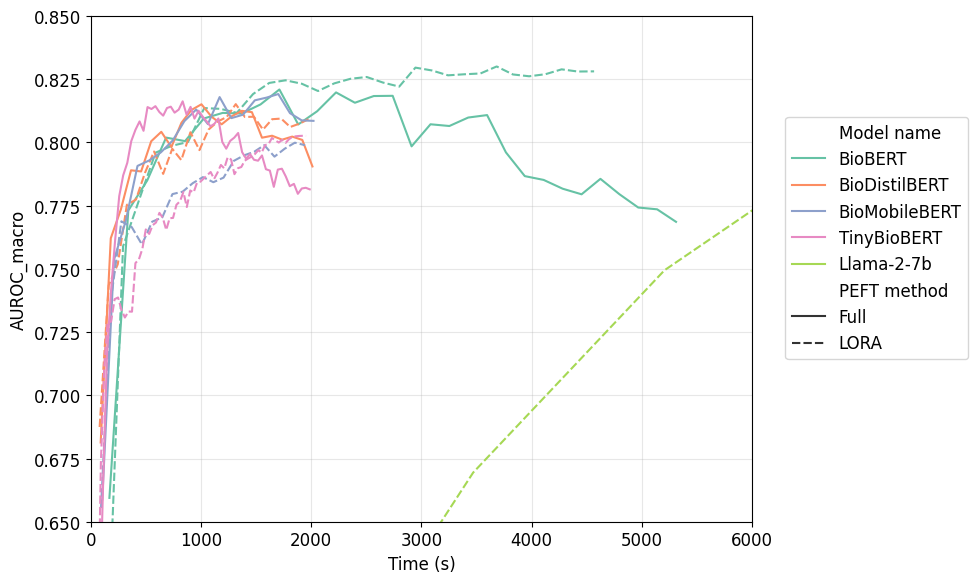

In [24]:
plot_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'PEFT method']]
plot_df['Model name'] = plot_df['Model name'].replace(MODEL_NAME_MAP)
plot_df['Time (s)'] = plot_df.groupby(['Model name', 'PEFT method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
plot_df = plot_df.loc[plot_df['tag'].str.contains('eval/roc_auc')]
plot_df.rename(columns={'value': 'AUROC_macro'}, inplace=True)
# fg = sns.FacetGrid(data=plot_df, col='peft_method', sharey=True, sharex=True, 
#                    legend_out=True, aspect = 1, height = 4, 
#                    col_order=['Full', 'LORA'])
# fg.map_dataframe(sns.lineplot, x='rel_time', y='value', hue='Model name', 
#                  hue_order=plot_df['Model name'].unique(), palette='Set2')
# fg.add_legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True, sharex=False)
sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
            hue='Model name', hue_order=HUE_ORDER, 
            style='PEFT method', style_order=['Full', 'LORA'], 
            palette=PALETTE, ax=ax, legend=True)
ax.set_xlim((0, 6000))
ax.set_ylim((0.65, 0.85))
ax.grid(True, which='both', alpha=0.3)

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
# plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# whole of llama model for sake of it

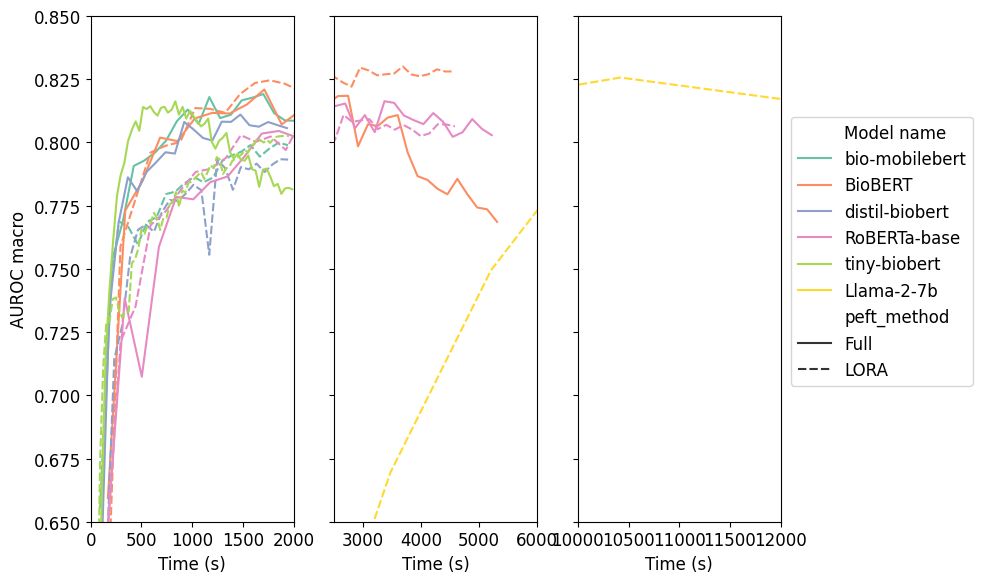

In [73]:
# can we do a 3 by plot with llama on its own at end - or add a single point with the max value of llama super imposed


fig, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True, sharex=False)
ax = ax.flatten()
for ax_num, xrange in enumerate([(0, 2000), (2500, 6000), (10000, 12000)]):
    sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
                hue='Model name', hue_order=plot_df['Model name'].unique(), 
                style='PEFT method', style_order=['Full', 'LORA'], 
                palette='Set2', ax=ax[ax_num], legend=ax_num==len(ax)-1)
    ax[ax_num].set_xlim(xrange)
    ax[ax_num].set_ylim((0.65, 0.85))
    
# add a single point showing the maximum value for Llama 2 on the right plot
# max_llama = plot_df.loc[plot_df['Model name'] == 'Llama-2-7b']['AUROC_macro'].max()
# ax[1].scatter(5990, max_llama, marker='x', s=150, c='black')

    
# set y label to AUROC macro
ax[0].set_ylabel("AUROC macro")

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

plt.tight_layout()
# change whitespace between subplots
plt.subplots_adjust(wspace=0.15)

# plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
# plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

#### plot with all same learning rate

In [10]:
# load in the few shot sensitivity logs
fs_logs_dir2 = '/mnt/sdh/effecient_ml/tb_2000_default_params/logs/' # here all use the same default lr

fs_logs_df2 = read_tb_files(fs_logs_dir2)
fs_logs_df2['datetime'] = fs_logs_df2['dir_name'].apply(lambda x: extract_datetime(x))
fs_logs_df2 = fs_logs_df2.loc[fs_logs_df2['Model name'].isin(
    [       
            'BioBERT',
            # 'distil-biobert',
            'BioDistilBERT',
            'BioMobileBERT',
            'TinyBioBERT',
            'Llama-2-7b'
            ])]
fs_logs_df2.loc[fs_logs_df2['Model name'] == 'bio-distilbert-uncased', 'Model name'] = 'bio-distilbert'

fs_logs_df2.shape

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/13227 [00:00<?, ?it/s]

(13227, 64)

In [16]:

fs_logs_df2 = fs_logs_df2.loc[fs_logs_df2['scheduler_type'] == 'linear']

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df2 = fs_logs_df2.loc[fs_logs_df2.groupby(
    ['Model name', 'PEFT method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]


In [18]:
plot_df2 = fs_logs_df2[['step', 'tag', 'value', 'wall_time', 'Model name', 'PEFT method']]
plot_df2['Model name'] = plot_df2['Model name'].replace(MODEL_NAME_MAP)
plot_df2['Time (s)'] = plot_df2.groupby(['Model name', 'PEFT method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
plot_df2 = plot_df2.loc[plot_df2['tag'].str.contains('eval/roc_auc')]

/tmp/ipykernel_2662/4019794445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df2['Model name'] = plot_df2['Model name'].replace(MODEL_NAME_MAP)
/tmp/ipykernel_2662/4019794445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df2['Time (s)'] = plot_df2.groupby(['Model name', 'PEFT method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values


In [19]:
plot_df2.head(60)

,step,tag,value,wall_time,Model name,PEFT method,Time (s)
706,200,eval/roc_auc_macro,0.707604,1.709648e+09,BioDistilBERT,Full,91.046409
707,400,eval/roc_auc_macro,0.675009,1.709648e+09,BioDistilBERT,Full,182.562105
708,600,eval/roc_auc_macro,0.688901,1.709648e+09,BioDistilBERT,Full,273.535055
709,800,eval/roc_auc_macro,0.688176,1.709648e+09,BioDistilBERT,Full,363.663473
710,1000,eval/roc_auc_macro,0.686162,1.709649e+09,BioDistilBERT,Full,453.741746
711,1200,eval/roc_auc_macro,0.690216,1.709649e+09,BioDistilBERT,Full,543.651332
712,1400,eval/roc_auc_macro,0.690500,1.709649e+09,BioDistilBERT,Full,633.866647
713,1600,eval/roc_auc_macro,0.683828,1.709649e+09,BioDistilBERT,Full,724.338558
714,1800,eval/roc_auc_macro,0.669151,1.709649e+09,BioDistilBERT,Full,814.329058
715,2000,eval/roc_auc_macro,0.671865,1.709649e+09,BioDistilBERT,Full,904.255546


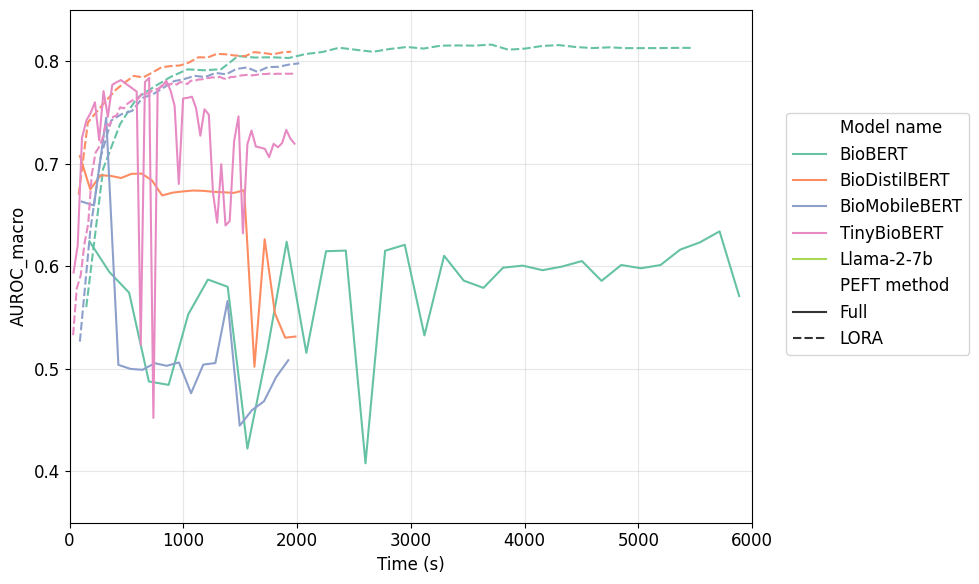

In [21]:

plot_df2.rename(columns={'value': 'AUROC_macro'}, inplace=True)
# fg = sns.FacetGrid(data=plot_df, col='peft_method', sharey=True, sharex=True, 
#                    legend_out=True, aspect = 1, height = 4, 
#                    col_order=['Full', 'LORA'])
# fg.map_dataframe(sns.lineplot, x='rel_time', y='value', hue='Model name', 
#                  hue_order=plot_df['Model name'].unique(), palette='Set2')
# fg.add_legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True, sharex=False)
sns.lineplot(data=plot_df2, x='Time (s)', y='AUROC_macro', 
            hue='Model name', hue_order=HUE_ORDER, 
            style='PEFT method', style_order=['Full', 'LORA'], 
            palette=PALETTE, ax=ax, legend=True)
ax.set_xlim((0, 6000))
ax.set_ylim((0.35, 0.85))
ax.grid(True, which='both', alpha=0.3)

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
plt.tight_layout()
# plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
# plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

### Efficiency Plot 1

This will use the best performing model from each of the time budget runs - this has some subtle issues in that the learning rate differences etc are quite influential 

Here we will do a combination of pure total_train_time + model_size + total flos




In [30]:
# tb_logs_dir = "/mnt/sdh/effecient_ml/tb_2000/logs/"
# # load in the few shot sensitivity logs
# tb_logs_df = read_tb_files(tb_logs_dir)

# # cls_results_df = produce_results_table(logs_df, 
# #                                 metric = ["f1",
# #                                         "accuracy",
# #                                         "precision",
# #                                         "recall",
# #                                         "auc", 
# #                                         "train/total_flos", "train/train_loss",
# #                                         "train/train_runtime", "train/train_samples_per_second",
# #                                         "train/train_steps_per_second"],
# #                                 mode = "all",
# #                                 groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
# #                                 task_type = "SEQ_CLS",
# #                                 value_aggregate_method = "max",
# #                                 )

# # do same for fs_logs_df

# first combine fs_logs_df with cls_results_df in order to get maximum of each? not sure it will work or not

all_logs_df = pd.concat([logs_df, fs_logs_df])

cls_results_df = produce_results_table(all_logs_df, # fs_logs_df
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second",
                                        "eval/samples_per_second",
                                        "eval/runtime"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

/tmp/ipykernel_17609/1093808666.py:24: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  all_logs_df = pd.concat([logs_df, fs_logs_df])


In [129]:
all_logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'eval/f1', 'test/f1'], dtype=object)

In [131]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'PEFT method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'f1_macro', 'f1_micro', 'f1_weighted', 'precision', 'recall',
       'roc_auc_macro', 'train/total_flos', 'train/train_loss',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second'],
      dtype='object', name='tag')

In [31]:
# add trainable params mapping
# tb_cls_results_df["PEFT_params"] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                      get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)
# tb_cls_results_df['PEFT_params_perc'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                      get(x['PEFT method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
# tb_cls_results_df['Total_params'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                      get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)
# tb_cls_results_df['full_model_size_GB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('model_size_GB', np.NaN), axis=1)
# tb_cls_results_df['full_model_size_MB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('model_size_MB', np.NaN), axis=1)
# tb_cls_results_df['peft_full_model_size_GB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
# tb_cls_results_df['peft_full_model_size_MB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('peft_model_size_MB', np.NaN), axis=1)


cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)
cls_results_df['full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_GB', np.NaN), axis=1)
cls_results_df['full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_MB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_MB', np.NaN), axis=1)



either we use the tb logs which have slightly optimised results but will have a fixed train time or we use cls_results

In [156]:
cls_results_df.shape

(136, 35)

In [104]:
cls_results_df.query("`Model name` == 'BioBERT' & task == 'MIMIC LoS' & few_shot_n == 250")["train/train_runtime"]

16    3420.683350
17    2786.532471
18    2799.647949
19    2626.601074
Name: train/train_runtime, dtype: float64

In [24]:
cls_results_df["train/total_flos"]

0      1.178996e+16
1      1.183130e+16
2      1.283238e+16
3      1.287760e+16
4      3.751990e+16
           ...     
221    1.889166e+16
222    2.108343e+16
223    2.109995e+16
224    2.115628e+16
225    2.108418e+16
Name: train/total_flos, Length: 226, dtype: float64

In [26]:
# get total flos for each model type
temp_df = cls_results_df.loc[cls_results_df['PEFT method'] == 'LORA']
temp_df['train/total_flos_scaled'] = temp_df['train/total_flos']/1e12
temp_df.groupby(["Model name"])["train/total_flos_scaled"].mean().reset_index().sort_values("train/total_flos_scaled", ascending=False)

/tmp/ipykernel_63639/4168866070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['train/total_flos_scaled'] = temp_df['train/total_flos']/1e12


,Model name,train/total_flos_scaled
8,Llama-2-7b,1.398980e+06
10,RoBERTa-base,5.129128e+04
1,BioBERT,2.843159e+04
2,BioClinicalBERT,2.627201e+04
0,BERTbase,2.609522e+04
5,ClinicalDistilBERT,1.343836e+04
3,BioDistilBERT,1.334017e+04
7,DistilBERTbase,1.334017e+04
14,distil-biobert,1.324082e+04
4,BioMobileBERT,6.265844e+03


In [32]:
# budget metrics to consider
budget_metrics = ["train/train_runtime", "train/total_flos", "full_model_size_MB",]
# create new efficiency metric as a linear combination of the above

# standardise each metric
for metric in budget_metrics:
    cls_results_df[f"{metric}_scaled"] = (cls_results_df[metric] - cls_results_df[metric].min()) / (cls_results_df[metric].max() - cls_results_df[metric].min())
    

cls_results_df["raw_efficiency"] = cls_results_df["train/train_runtime_scaled"] + cls_results_df["train/total_flos_scaled"] + cls_results_df["full_model_size_MB_scaled"]


# rescale effiency to be between 0 and 1 and round to 3 dp
 
# cls_results_df["efficiency"] = (1 - (cls_results_df["raw_efficiency"] - cls_results_df["raw_efficiency"].min()) / (cls_results_df["raw_efficiency"].max() - cls_results_df["raw_efficiency"].min())).round(3)
cls_results_df["efficiency"] = (1 - cls_results_df["raw_efficiency"]).round(3)


# take log of raw efficiency
cls_results_df["log_efficiency"] = (100 - np.log(cls_results_df["raw_efficiency"]))/100



# now rescale between 0 and 1
cls_results_df["log_efficiency"] = (cls_results_df["log_efficiency"] - cls_results_df["log_efficiency"].min()) / (cls_results_df["log_efficiency"].max() - cls_results_df["log_efficiency"].min())

# or just scaled flops?
cls_results_df['total_flos_scaled'] = cls_results_df['train/total_flos']/1e12

# take log of the total flos scaled
cls_results_df["log_total_flos_scaled"] = (100 - np.log(cls_results_df["total_flos_scaled"]))

In [25]:
print(float(1e-12))

1e-12


In [205]:
# find row where effiency is not nan
cls_results_df[cls_results_df["efficiency"].notna()]["Model name"]

0              BERT-base
1              BERT-base
2              BERT-base
3              BERT-base
4              BERT-base
             ...        
131    tiny-clinicalbert
132    tiny-clinicalbert
133    tiny-clinicalbert
134    tiny-clinicalbert
135    tiny-clinicalbert
Name: Model name, Length: 136, dtype: object

In [106]:
cls_results_df["model_name_or_path"].unique()

array(['bert-base-uncased', 'dmis-lab/biobert-v1.1',
       'emilyalsentzer/Bio_ClinicalBERT', 'nlpie/bio-distilbert-uncased',
       'nlpie/bio-mobilebert', 'nlpie/clinical-distilbert',
       'nlpie/clinical-mobilebert', 'distilbert-base-uncased',
       'meta-llama/Llama-2-7b-hf', 'google/mobilebert-uncased',
       'roberta-base', 'huawei-noah/TinyBERT_General_4L_312D',
       'nlpie/tiny-biobert', 'nlpie/tiny-clinicalbert',
       'nlpie/distil-biobert'], dtype=object)

In [107]:
cls_results_df["Model name"].unique()

array(['BERTbase', 'BioBERT', 'BioClinicalBERT', 'BioDistilBERT',
       'BioMobileBERT', 'ClinicalDistilBERT', 'ClinicalMobileBERT',
       'DistilBERTbase', 'Llama-2-7b', 'MobileBERT', 'RoBERTa-base',
       'TinyBERT', 'TinyBioBERT', 'TinyClinicalBERT', 'distil-biobert'],
      dtype=object)

In [207]:
cls_results_df.query("`Model name` == 'Llama-2-7b'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB,raw_efficiency,efficiency,log_efficiency
40,40,Llama-2-7b,meta-llama/Llama-2-7b-hf,mimic-mp,250.0,LORA,0.898188,0.902812,0.669392,0.902812,...,4194304,0.063479,6607351808,24.614304,25205.046875,0.015656,16.03125,1.398980e+18,0.0,0.582177


In [33]:
PEFT_methods_to_plot = ['LORA', 'Full']
ef_plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
ef_plot_df =  ef_plot_df.loc[ef_plot_df['task'] != 'mednli']
ef_plot_df = ef_plot_df.loc[ef_plot_df['Model name'].isin(
    ['BioBERT','BioDistilBERT','BioMobileBERT', 'TinyBioBERT', 'RoBERTa-base','Llama-2-7b'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
ef_plot_df = ef_plot_df.loc[ef_plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
ef_plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
ef_plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
ef_plot_df['roc_auc_macro'] = ef_plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [126]:
ef_plot_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'PEFT method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'PEFT_params', 'PEFT_params_perc', 'Total_params', 'full_model_size_GB',
       'full_model_size_MB', 'peft_full_model_size_GB',
       'peft_full_model_size_MB'],
      dtype='object', name='tag')

In [26]:
ef_plot_df.query(" `task` == 'MIMIC MP'")[[ "Model name",
                                            "PEFT method",
                                           "eval/roc_auc_macro", "roc_auc_macro", "train/train_runtime",
                                           "train/total_flos","eval/runtime", "full_model_size_MB", "efficiency",
                                           "raw_efficiency", "log_efficiency"]]

tag,Model name,PEFT method,eval/roc_auc_macro,roc_auc_macro,train/train_runtime,train/total_flos,eval/runtime,full_model_size_MB,efficiency,raw_efficiency,log_efficiency
112,TinyBioBERT,LORA,0.802615,0.804,1970.063843,5.852876e+15,10.747100,52.928017,0.996,5.852876e+15,0.712579
110,TinyBioBERT,Full,0.816259,0.804,2000.935547,4.771707e+15,11.513100,52.928017,0.997,4.771707e+15,0.739152
90,RoBERTa-base,LORA,0.820007,0.825,4722.450195,5.129128e+16,40.207500,475.491219,0.964,5.129128e+16,0.430155
89,RoBERTa-base,Full,0.851135,0.806,5439.417969,5.025174e+16,38.700001,475.491219,0.965,5.025174e+16,0.432819
80,Llama-2-7b,LORA,0.846324,0.838,43390.453125,1.398980e+18,718.354309,25205.046875,0.000,1.398980e+18,0.000000
55,BioMobileBERT,LORA,0.799893,0.816,2001.018555,1.008930e+16,25.156300,93.776375,0.993,1.008930e+16,0.641727
53,BioMobileBERT,Full,0.819139,0.811,2355.455566,9.980649e+15,25.775200,93.776375,0.993,9.980649e+15,0.643135
43,BioDistilBERT,LORA,0.815145,0.822,2000.842651,2.148109e+16,23.411900,255.413094,0.985,2.148109e+16,0.543399
41,BioDistilBERT,Full,0.815090,0.803,2013.183594,2.108343e+16,22.792801,255.413094,0.985,2.108343e+16,0.545831
22,BioBERT,LORA,0.830042,0.832,4659.600098,5.059875e+16,40.369499,413.176765,0.964,5.059875e+16,0.431924


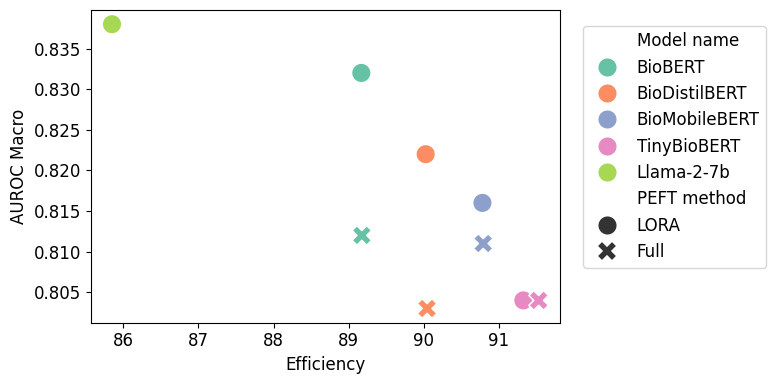

In [53]:
task = "MIMIC MP"
metric = "roc_auc_macro"
fig, ax = plt.subplots(figsize=(8,4))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.scatterplot(data = ef_plot_df.query("task == @task & `Model name` != 'RoBERTa-base'"),
        x = "log_total_flos_scaled", # log_total_flos_scaled | log_efficiency
        y = metric,
        hue = "Model name",
        hue_order = HUE_ORDER,
        style = "PEFT method",
        style_order = ['LORA', 'Full'],
        ax = ax,
        legend = True,
        palette = PALETTE,
        s = 200
        )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
# plt.legend(loc='upper right', 
#         bbox_to_anchor=(1.0, -0.2),  
#         fancybox=True, shadow=False, 
#         ncol=3)


plt.legend(bbox_to_anchor=(1.05, 0.95), loc=2, borderaxespad=0.)
# rotate x tick labels by 45
plt.xticks(rotation=0
            )
plt.xlabel("Efficiency")

# fig.suptitle("PEFT Method", x=0.55, y=0.4, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)
plt.tight_layout()
# save
# plt.savefig(f'{save_path}/effiency_{task}_{metric}.png', bbox_inches='tight', dpi = 300)

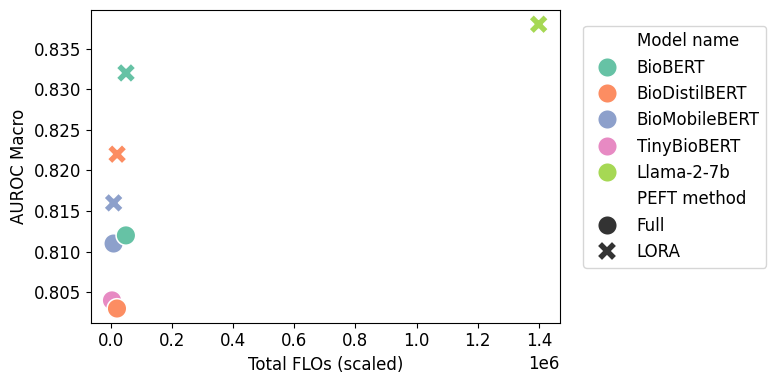

In [21]:
# just scaled FLOs
task = "MIMIC MP"
metric = "roc_auc_macro"
fig, ax = plt.subplots(figsize=(8,4))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.scatterplot(data = ef_plot_df.query("task == @task & `Model name` != 'RoBERTa-base'"),
        x = "total_flos_scaled",
        y = metric,
        hue = "Model name",
        hue_order = HUE_ORDER,
        style = "PEFT method",
        style_order = ['Full', 'LORA'],
        ax = ax,
        legend = True,
        palette = PALETTE,
        s = 200
        )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
# plt.legend(loc='upper right', 
#         bbox_to_anchor=(1.0, -0.2),  
#         fancybox=True, shadow=False, 
#         ncol=3)


plt.legend(bbox_to_anchor=(1.05, 0.95), loc=2, borderaxespad=0.)
# rotate x tick labels by 45
plt.xticks(rotation=0
            )
plt.xlabel("Total FLOs (scaled)")

# fig.suptitle("PEFT Method", x=0.55, y=0.4, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)
plt.tight_layout()
# save
plt.savefig(f'{save_path}/totalFLOs_{task}_{metric}.png', bbox_inches='tight', dpi = 300)

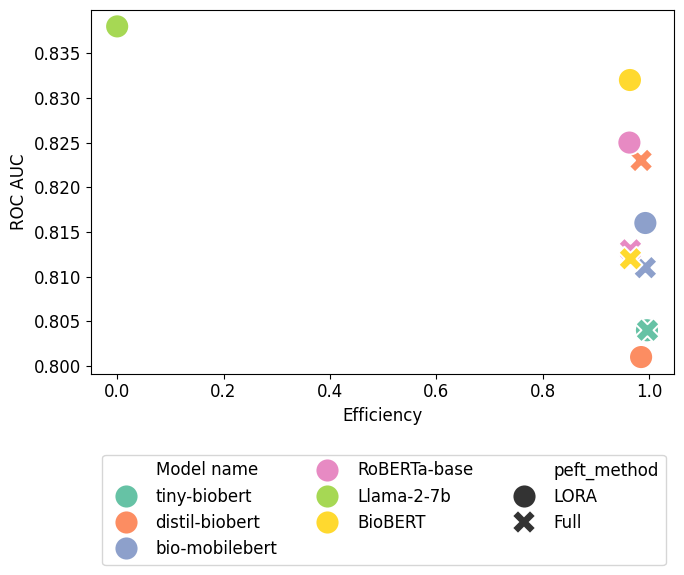

In [212]:
# raw efficiency 
task = "MIMIC MP"
metric = "roc_auc_macro"
fig, ax = plt.subplots(figsize=(7,6))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.scatterplot(data = ef_plot_df.query("task == @task"),
        x = "efficiency",
        y = metric,
        hue = "Model name",
        
        style = "PEFT method",
        ax = ax,
        legend = True,
        palette = "Set2",
        s = 300
        )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
plt.legend(loc='upper right', 
        bbox_to_anchor=(1.0, -0.2),  
        fancybox=True, shadow=False, 
        ncol=3)
# rotate x tick labels by 45
plt.xticks(rotation=0
            )
plt.xlabel("Efficiency")

# fig.suptitle("PEFT Method", x=0.55, y=0.4, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)
plt.tight_layout()
# save
# plt.savefig(f'{save_path}/effiency_{task}_{metric}.png', bbox_inches='tight', dpi = 300)

### Effiency plot version 2

This is a slightly more realistic approach - where we find the total flos at the point of the best validation performance, as well as the time taken to reach that point and each model & peft method utilises the same default params. We also combine total params + trainable peft params as metrics of efficiency - this is a bit of a hack but it is a good way to compare "Full" and "PEFT" models which generally have identical FLOPS and if we only take trainable params into account then we are not accounting for the full model size and Llama ends up looking very efficient when it is not.

In [26]:
# sanity check with the default runs
# extract llama 2 results from fs_logs_df
llama_results = fs_logs_df.query("`Model name` == 'Llama-2-7b'")
# combine logs_df with PEFT method ['LORA','FULL] and llama_results
peft_to_keep = ['LORA', 'Full']
combined_df = pd.concat([logs_df, llama_results])

# remove any rows where the PEFT method is not in peft_to_keep
combined_df = combined_df.loc[combined_df['PEFT method'].isin(peft_to_keep)]

# rename to fs_logs_df
fs_logs_df = combined_df.copy()

In [141]:
fs_logs_df["Model name"].unique() 

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'Llama-2-7b',
       'TinyBioBERT'], dtype=object)

In [27]:
# groupby model name, peft method, task and random seed and aggregate mean for [value, tag, wall_time and step] and first for tag
fs_logs_df = fs_logs_df.groupby(['Model name', 'PEFT method', 'task', 'tag', 'task_type', 'model_name_or_path', 'few_shot_n', 'step']).agg(
    {'value': 'mean', 'wall_time': 'mean'}).reset_index()

In [21]:
fs_logs_df["Model name"].unique()

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'Llama-2-7b',
       'TinyBioBERT'], dtype=object)

In [22]:
fs_logs_df["task"].unique()

array(['ICD9-Triage', 'MIMIC LoS', 'MIMIC MP', 'i2b2-2010-NER',
       'i2b2-2010-RE', 'i2b2-2012-NER', 'i2b2-2014-NER'], dtype=object)

In [33]:
# subset BioBERT and task == MP
fs_logs_df.query("`Model name` == 'TinyBioBERT' & task == 'MIMIC MP' & few_shot_n == 250 & tag == 'eval/roc_auc_macro'")

,Model name,PEFT method,task,tag,task_type,model_name_or_path,few_shot_n,step,value,wall_time
12866,TinyBioBERT,Full,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,1062,0.754224,1.707331e+09
12867,TinyBioBERT,Full,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,2124,0.791698,1.707331e+09
12868,TinyBioBERT,Full,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,3186,0.796968,1.707331e+09
12869,TinyBioBERT,Full,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,4248,0.798697,1.707331e+09
12870,TinyBioBERT,Full,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,5310,0.798537,1.707331e+09
14817,TinyBioBERT,LORA,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,1062,0.632431,1.707323e+09
14818,TinyBioBERT,LORA,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,2124,0.726958,1.707324e+09
14819,TinyBioBERT,LORA,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,3186,0.744625,1.707324e+09
14820,TinyBioBERT,LORA,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,4248,0.751356,1.707324e+09
14821,TinyBioBERT,LORA,MIMIC MP,eval/roc_auc_macro,SEQ_CLS,nlpie/tiny-biobert,250,5310,0.753153,1.707324e+09


In [28]:
eff_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'task', 'PEFT method']]
eff_df = eff_df.loc[eff_df['task'] == 'MIMIC MP']
eff_df['rel_time'] = eff_df.groupby(['Model name', 'PEFT method','task'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
best_rel_time = eff_df.loc[eff_df['tag'] == 'eval/roc_auc_macro'][['Model name', 'PEFT method', 'rel_time', 'value','task']]
best_rel_time = best_rel_time.groupby(['Model name', 'PEFT method','task']).apply(lambda x: x.nlargest(1, 'value')).reset_index(drop=True)
best_rel_time.index = best_rel_time.apply(lambda x: f'{x["Model name"]}_{x["PEFT method"]}', axis=1).values
best_rel_time

,Model name,PEFT method,rel_time,value,task
BioBERT_Full,BioBERT,Full,1508.148605,0.824373,MIMIC MP
BioBERT_LORA,BioBERT,LORA,3099.144011,0.818569,MIMIC MP
BioDistilBERT_Full,BioDistilBERT,Full,774.645568,0.816651,MIMIC MP
BioDistilBERT_LORA,BioDistilBERT,LORA,1325.914656,0.809654,MIMIC MP
BioMobileBERT_Full,BioMobileBERT,Full,912.668686,0.816986,MIMIC MP
BioMobileBERT_LORA,BioMobileBERT,LORA,1528.734967,0.791482,MIMIC MP
Llama-2-7b_LORA,Llama-2-7b,LORA,27785.839342,0.846324,MIMIC MP
TinyBioBERT_Full,TinyBioBERT,Full,605.023822,0.798697,MIMIC MP
TinyBioBERT_LORA,TinyBioBERT,LORA,625.297699,0.753153,MIMIC MP
roberta-base-mimic-note-custom_pretraining_max_epoch_2_mlm_loss_only_LORA,roberta-base-mimic-note-custom_pretraining_max...,LORA,2467.133142,0.822617,MIMIC MP


In [129]:
best_rel_time

,Model name,PEFT method,rel_time,value
BioBERT_Full,BioBERT,Full,399.533680,0.817720
BioBERT_LORA,BioBERT,LORA,331.857221,0.814045
BioDistilBERT_Full,BioDistilBERT,Full,2211.252676,0.803191
BioDistilBERT_LORA,BioDistilBERT,LORA,3628.194073,0.800701
BioMobileBERT_Full,BioMobileBERT,Full,242.445678,0.806083
BioMobileBERT_LORA,BioMobileBERT,LORA,2187.533021,0.782504
TinyBioBERT_Full,TinyBioBERT,Full,84.772390,0.788891
TinyBioBERT_LORA,TinyBioBERT,LORA,1412.313682,0.725347


In [29]:
# Add up all evaltimes and test times because tensorboard logs them for
# each evaluation or test loop

# we want to exclude any non MIMIC MP tasks
eval_time_df = produce_results_table(fs_logs_df.query("task == 'MIMIC MP'"),
                    metric = ["eval/runtime", "test/runtime"],
                    mode = "all",
                    groupby_list = ["Model name", "model_name_or_path", 
                                    "task", "few_shot_n", "PEFT method", ],
                    task_type = "SEQ_CLS",
                    value_aggregate_method = "sum",
                    )
# Do not add up train time because tensorboard logs the total train
# time, not for each epoch
train_time_df = produce_results_table(fs_logs_df.query("task == 'MIMIC MP'"),
                    metric = ["train/total_flos", "train/train_runtime"],
                    mode = "all",
                    groupby_list = ["Model name", "model_name_or_path", 
                                    "task", "few_shot_n", "PEFT method"],
                    task_type = "SEQ_CLS",
                    value_aggregate_method = "max",
                    )

In [32]:
train_time_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,train/total_flos,train/train_runtime
0,0,BioBERT,dmis-lab/biobert-v1.1,MIMIC MP,250,Full,4.187659e+16,3777.973958
1,1,BioBERT,dmis-lab/biobert-v1.1,MIMIC MP,250,LORA,4.202153e+16,3100.790609
2,2,BioDistilBERT,nlpie/bio-distilbert-uncased,MIMIC MP,250,Full,2.108343e+16,1943.378092
3,3,BioDistilBERT,nlpie/bio-distilbert-uncased,MIMIC MP,250,LORA,2.148109e+16,1658.474121
4,4,BioMobileBERT,nlpie/bio-mobilebert,MIMIC MP,250,Full,9.980649e+15,2283.924154
5,5,BioMobileBERT,nlpie/bio-mobilebert,MIMIC MP,250,LORA,1.008930e+16,1911.248901
6,6,Llama-2-7b,meta-llama/Llama-2-7b-hf,MIMIC MP,250,LORA,1.398980e+18,43390.453125
7,7,TinyBioBERT,nlpie/tiny-biobert,MIMIC MP,250,Full,2.282186e+15,756.881226
8,8,TinyBioBERT,nlpie/tiny-biobert,MIMIC MP,250,LORA,2.311781e+15,626.542338


In [33]:
eval_time_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,eval/runtime,runtime
0,0,BioBERT,dmis-lab/biobert-v1.1,MIMIC MP,250,Full,196.523098,76.337832
1,1,BioBERT,dmis-lab/biobert-v1.1,MIMIC MP,250,LORA,200.176598,77.703334
2,2,BioDistilBERT,nlpie/bio-distilbert-uncased,MIMIC MP,250,Full,107.607633,40.561467
3,3,BioDistilBERT,nlpie/bio-distilbert-uncased,MIMIC MP,250,LORA,112.392801,42.565267
4,4,BioMobileBERT,nlpie/bio-mobilebert,MIMIC MP,250,Full,122.977599,46.963434
5,5,BioMobileBERT,nlpie/bio-mobilebert,MIMIC MP,250,LORA,122.823267,47.196100
6,6,Llama-2-7b,meta-llama/Llama-2-7b-hf,MIMIC MP,250,LORA,17891.722046,1428.905884
7,7,TinyBioBERT,nlpie/tiny-biobert,MIMIC MP,250,Full,56.365367,20.010967
8,8,TinyBioBERT,nlpie/tiny-biobert,MIMIC MP,250,LORA,49.668800,17.618933


In [22]:
best_rel_time

,Model name,PEFT method,rel_time,value,task
0,BioBERT,Full,1508.148605,0.824373,MIMIC MP
1,BioBERT,LORA,3099.144011,0.818569,MIMIC MP
2,BioDistilBERT,Full,774.645568,0.816651,MIMIC MP
3,BioDistilBERT,LORA,1325.914656,0.809654,MIMIC MP
4,BioMobileBERT,Full,912.668686,0.816986,MIMIC MP
5,BioMobileBERT,LORA,1528.734967,0.791482,MIMIC MP
6,Llama-2-7b,LORA,27785.839342,0.846324,MIMIC MP
7,TinyBioBERT,Full,605.023822,0.798697,MIMIC MP
8,TinyBioBERT,LORA,625.297699,0.753153,MIMIC MP


In [30]:
time_df = pd.merge(eval_time_df, train_time_df, on=['Model name', 'model_name_or_path', 'task', 'few_shot_n', 'PEFT method'])
time_df['eval_test_time'] = time_df['eval/runtime'] + time_df['runtime']
time_df = time_df[['Model name', 'model_name_or_path', 'PEFT method', 'eval_test_time', 'train/total_flos', 'train/train_runtime']]
time_df.index = time_df.apply(lambda x: f'{x["Model name"]}_{x["PEFT method"]}', axis=1).values
time_df['best_rel_time'] = best_rel_time.loc[time_df.index, 'rel_time'].values
time_df['best_rel_time'] = time_df['best_rel_time'] - time_df['eval_test_time']
time_df['best_flos'] = (time_df['train/total_flos'] / time_df['train/train_runtime']) * time_df['best_rel_time']
time_df['best_value'] = best_rel_time.loc[time_df.index, 'value'].values

In [31]:
time_df

tag,Model name,model_name_or_path,PEFT method,eval_test_time,train/total_flos,train/train_runtime,best_rel_time,best_flos,best_value
BioBERT_Full,BioBERT,dmis-lab/biobert-v1.1,Full,272.860930,4.187659e+16,3777.973958,1235.287675,1.369243e+16,0.824373
BioBERT_LORA,BioBERT,dmis-lab/biobert-v1.1,LORA,277.879931,4.202153e+16,3100.790609,2821.264079,3.823343e+16,0.818569
BioDistilBERT_Full,BioDistilBERT,nlpie/bio-distilbert-uncased,Full,148.169100,2.108343e+16,1943.378092,626.476468,6.796552e+15,0.816651
BioDistilBERT_LORA,BioDistilBERT,nlpie/bio-distilbert-uncased,LORA,154.958068,2.148109e+16,1658.474121,1170.956589,1.516660e+16,0.809654
BioMobileBERT_Full,BioMobileBERT,nlpie/bio-mobilebert,Full,169.941033,9.980649e+15,2283.924154,742.727653,3.245688e+15,0.816986
BioMobileBERT_LORA,BioMobileBERT,nlpie/bio-mobilebert,LORA,170.019367,1.008930e+16,1911.248901,1358.715600,7.172527e+15,0.791482
Llama-2-7b_LORA,Llama-2-7b,meta-llama/Llama-2-7b-hf,LORA,19320.627930,1.398980e+18,43390.453125,8465.211413,2.729324e+17,0.846324
TinyBioBERT_Full,TinyBioBERT,nlpie/tiny-biobert,Full,76.376334,2.282186e+15,756.881226,528.647488,1.594004e+15,0.798697
TinyBioBERT_LORA,TinyBioBERT,nlpie/tiny-biobert,LORA,67.287733,2.311781e+15,626.542338,558.009966,2.058914e+15,0.753153
roberta-base-mimic-note-custom_pretraining_max_epoch_2_mlm_loss_only_LORA,roberta-base-mimic-note-custom_pretraining_max...,/mnt/sdc/niallt/saved_models/language_modellin...,LORA,277.283600,4.231017e+16,3086.001221,2189.849542,3.002362e+16,0.822617


In [35]:
trainable_params_mapping

{'bert-base-uncased': {'Full': {'FLOPs': '6.81e+08',
   'full_model_size_GB': 0.8157982006669044,
   'full_model_size_MB': 835.3773574829102,
   'model_size_GB': 0.40785885602235794,
   'model_size_MB': 417.64746856689453,
   'n_peft_params': 109482240,
   'n_peft_params_perc': 99.99859522567809,
   'n_trainable_params': 109483778,
   'peft_full_model_size_GB': 0.8158550411462784,
   'peft_full_model_size_MB': 835.4355621337891,
   'peft_model_size_GB': 0.40785885602235794,
   'peft_model_size_MB': 417.64746856689453,
   'raw_FLOPS': 680683008.0,
   'total_params': 109483778},
  'IA3': {'FLOPs': None,
   'full_model_size_GB': 0.8157982006669044,
   'full_model_size_MB': 835.3773574829102,
   'model_size_GB': 0.40785885602235794,
   'model_size_MB': 417.64746856689453,
   'n_peft_params': 64512,
   'n_peft_params_perc': 0.058923797825098795,
   'n_trainable_params': 66050,
   'peft_full_model_size_GB': 0.4084585942327976,
   'peft_full_model_size_MB': 418.26160049438477,
   'peft_model_

In [32]:
# add PEFT params and total params to time_df
time_df["PEFT_params"] = time_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)

# same for total params
time_df['Total_params'] = time_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)

In [33]:
# import standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

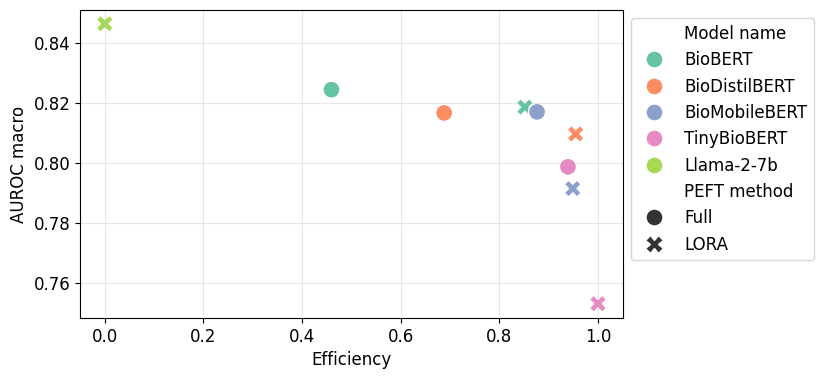

In [36]:
plot_df = time_df.filter(['Model name', 'PEFT method', 'best_flos', 'best_rel_time', 'best_value', 'PEFT_params', 'Total_params']).reset_index(drop=True)



plot_df.columns.name = None
# plot_df['Model name'] = plot_df['Model name'].replace(MODEL_NAME_MAP)
for c in ['best_flos', 'PEFT_params','Total_params', 'best_rel_time']:
    #  min max scaling
    plot_df[f'{c}'] = (plot_df[c] - plot_df[c].min()) / (plot_df[c].max() - plot_df[c].min())
    
    # use standard scaler
    # plot_df[f'{c}'] = scaler.fit_transform(plot_df[[c]])
    

# Efficiency = how many times more efficient than Llama
###### linear combination
# plot_df['Efficiency'] = plot_df['best_flos'] + plot_df['PEFT_params'] + plot_df['Total_params']
# plot_df['Efficiency'] = (plot_df['best_flos'] + plot_df['PEFT_params'])/2
# plot_df['Efficiency'] = plot_df['Efficiency']/plot_df['Efficiency'].max()
# plot_df['Efficiency'] = 1/plot_df['Efficiency']

#####  average - average of z-scores
# plot_df['Efficiency'] = -plot_df[['best_flos', 'PEFT_params', '']].mean(axis=1)
# plot_df['Efficiency'] = -plot_df[['best_rel_time', 'PEFT_params','Total_params']].mean(axis=1)

plot_df['Efficiency'] = -plot_df[['best_rel_time', 'PEFT_params','Total_params']].mean(axis=1)




# rescale between - and 1
plot_df['Efficiency'] = (plot_df['Efficiency'] - plot_df['Efficiency'].min()) / (plot_df['Efficiency'].max() - plot_df['Efficiency'].min())

# set fig size
plt.figure(figsize=(7, 4))

plot_df = plot_df.rename(columns={'best_value': 'AUROC macro'})
sns.scatterplot(data=plot_df, x='Efficiency', y='AUROC macro', 
                hue='Model name', hue_order=HUE_ORDER,
                style='PEFT method', style_order=['Full', 'LORA'], 
                s=150, palette=PALETTE)
plt.legend(bbox_to_anchor=(1, 1.0), loc=2)
# add grid
plt.grid(alpha=0.3)
# save fig and show
plt.savefig(f'{save_path}/holistic_efficiency_vs_auroc.pdf', bbox_inches='tight', dpi=300)
plt.show()




In [26]:
save_path

'/mnt/sdd/efficient_ml_data/figures_and_plots/'

In [23]:
plot_df.sort_values('Efficiency', ascending=False)

,Model name,PEFT method,best_flos,best_rel_time,AUROC macro,PEFT_params,Total_params,Efficiency
8,TinyBioBERT,LORA,0.001713,0.003700,0.753153,0.000000,0.000000,1.000000
3,BioDistilBERT,LORA,0.050021,0.080930,0.809654,0.006946,0.008050,0.954668
5,BioMobileBERT,LORA,0.020559,0.104588,0.791482,0.001490,0.001624,0.948881
7,TinyBioBERT,Full,0.000000,0.000000,0.798697,0.127614,0.000000,0.939093
4,BioMobileBERT,Full,0.006087,0.026974,0.816986,0.226530,0.001624,0.876417
1,BioBERT,LORA,0.135032,0.288868,0.818569,0.002171,0.014323,0.851726
2,BioDistilBERT,Full,0.019174,0.012326,0.816651,0.617952,0.008050,0.688065
0,BioBERT,Full,0.044588,0.089036,0.824373,1.000000,0.014323,0.459492
6,Llama-2-7b,LORA,1.000000,1.000000,0.846324,0.038193,1.000000,0.000000


# NER tasks

In [17]:
ner_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BERT-base,bert-base-uncased,i2b2-2010-NER,250.0,Full,0.927843,0.938022,0.840604,0.835983,0.847973,0.806471,0.807763,0.805184
1,1,BERT-base,bert-base-uncased,i2b2-2010-NER,250.0,LORA,0.893014,0.908728,0.691431,0.691139,0.701014,0.672783,0.675753,0.669838
2,2,BERT-base,bert-base-uncased,i2b2-2012-NER,250.0,Full,0.896997,0.904368,0.815264,0.797377,0.836096,0.792244,0.771275,0.814386
3,3,BERT-base,bert-base-uncased,i2b2-2012-NER,250.0,LORA,0.862989,0.867565,0.717303,0.700615,0.734807,0.697306,0.676653,0.719260
4,4,BERT-base,bert-base-uncased,i2b2-2014-NER,250.0,Full,0.997375,0.997420,0.973744,0.974541,0.972948,0.973636,0.975124,0.972154


In [18]:
ner_results_df["Model name"].unique()

array(['BERT-base', 'Bio-ClinicalBERT', 'BioBERT', 'DistilBERT-base',
       'TinyBERT_General_4L_312D', 'bio-distilbert-uncased',
       'bio-mobilebert', 'clinical-distilbert', 'clinical-mobilebert',
       'distil-biobert', 'mobilebert-uncased', 'tiny-biobert',
       'tiny-clinicalbert'], dtype=object)

In [50]:
PEFT_methods_to_plot = [ "IA3","LORA", "Full"]

In [27]:
plot_df = ner_results_df.loc[ner_results_df['few_shot_n'] == 250].copy()

plot_df = plot_df.loc[plot_df['Model name'].isin(
    [
    'BioBERT',
    # 'distil-biobert',
    'BioDistilBERT',
    'BioMobileBERT',
    'TinyBioBERT'])]  # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1'], 
                            ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)


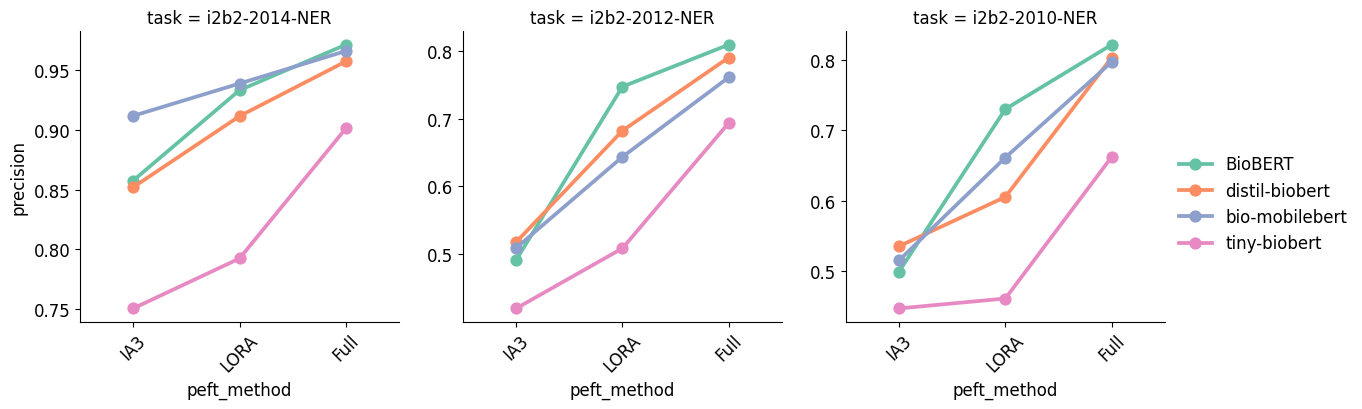

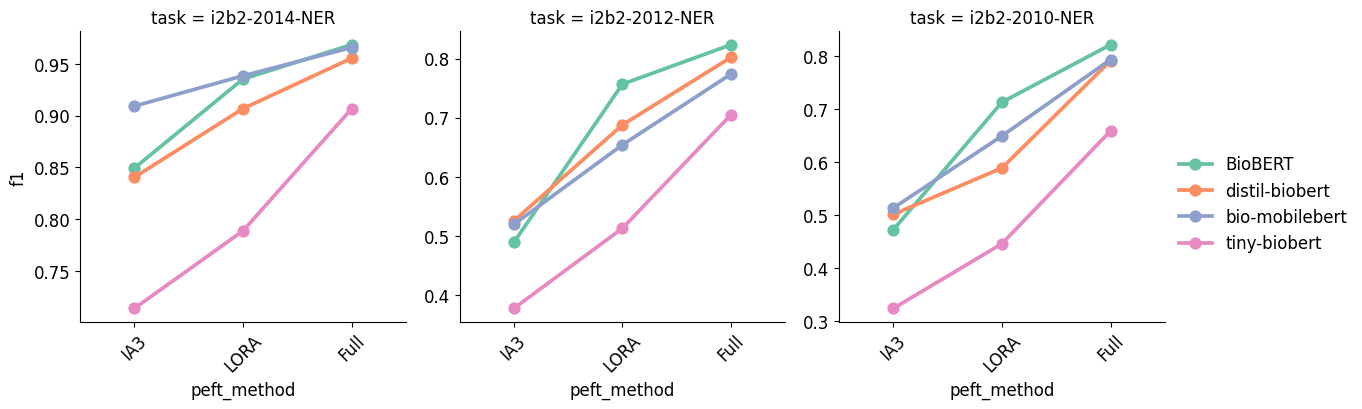

In [149]:
metrics = ['precision', 'f1']

  
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='PEFT method', y=metric, hue='Model name', 
                    order=PEFT_methods_to_plot, 
                    hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # plt.savefig(f'{save_path}/NER_{metric}_PEFT methods.png', bbox_inches='tight')
    plt.show()

In [19]:
ner_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,random_seed,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,12.0,0.830870,0.851808,0.477532,0.492891,0.464101,0.475029,0.502972,0.450027
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,34.0,0.829707,0.850812,0.473423,0.490476,0.458179,0.470815,0.498927,0.445703
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,56.0,0.831513,0.850911,0.463846,0.482786,0.446336,0.473074,0.502161,0.447172
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,12.0,0.905214,0.921422,0.719969,0.745051,0.696521,0.696060,0.713149,0.679772
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,34.0,0.902597,0.923314,0.723340,0.742212,0.705403,0.693984,0.707952,0.680555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,92,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,IA3,34.0,0.970365,0.970553,0.713376,0.749199,0.680822,0.712582,0.746793,0.681368
93,93,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,IA3,56.0,0.970563,0.970278,0.711907,0.748859,0.680822,0.714500,0.749480,0.682641
94,94,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,LORA,12.0,0.983310,0.982972,0.819464,0.822859,0.816096,0.821379,0.827076,0.815761
95,95,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,LORA,34.0,0.981364,0.981392,0.799694,0.798634,0.806678,0.796691,0.797751,0.795633


In [30]:
# F1 micro for I2B2-2010-RE | I2B2-2012-NER | I2B2-2014-NER
metric = "f1"
stat = "median"
task = "i2b2-2014-NER"
# plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])[metric].median().round(3).reset_index().pivot_table(index=['Model name', 'PEFT method'],
#                                                                                                         columns=['task',],
#                                                                                                         values=metric).reset_index()


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(f1_micro=(metric, stat), 
                  std=(metric, "std")
                  ).round(3).reset_index()

,Model name,PEFT method,task,f1_micro,std
0,BioBERT,Full,i2b2-2014-NER,0.967,0.001
1,BioBERT,IA3,i2b2-2014-NER,0.850,0.001
2,BioBERT,LORA,i2b2-2014-NER,0.935,0.000
3,BioDistilBERT,Full,i2b2-2014-NER,0.967,0.001
4,BioDistilBERT,IA3,i2b2-2014-NER,0.883,0.000
5,BioDistilBERT,LORA,i2b2-2014-NER,0.940,0.001
6,BioMobileBERT,Full,i2b2-2014-NER,0.966,0.000
7,BioMobileBERT,IA3,i2b2-2014-NER,0.908,0.000
8,BioMobileBERT,LORA,i2b2-2014-NER,0.941,0.001
9,TinyBioBERT,Full,i2b2-2014-NER,0.906,0.003


In [22]:
# make a latex table from this

ner_paper_results = plot_df.groupby(['Model name', 'PEFT method', 'task'])['f1'].max().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='f1').reset_index()
print(ner_paper_results.to_latex(
            caption = "PEFT results for NER tasks",
            label = "tab:peft-ner-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


# do same as above but for NER


\begin{table}[htp]
\centering
\caption{PEFT results for NER tasks}
\label{tab:peft-ner-results}
\begin{tabular}{llrrr}
\toprule
   Model name & PEFT method &  i2b2-2010-NER &  i2b2-2012-NER &  i2b2-2014-NER \\
\midrule
      BioBERT &         IA3 &          0.475 &          0.491 &          0.850 \\
      BioBERT &        LORA &          0.697 &          0.754 &          0.936 \\
BioDistilBERT &        Full &          0.806 &          0.798 &          0.967 \\
BioDistilBERT &         IA3 &          0.504 &          0.504 &          0.883 \\
BioDistilBERT &        LORA &          0.718 &          0.729 &          0.942 \\
BioMobileBERT &        Full &          0.800 &          0.777 &          0.966 \\
BioMobileBERT &         IA3 &          0.517 &          0.517 &          0.909 \\
BioMobileBERT &        LORA &          0.651 &          0.655 &          0.941 \\
  TinyBioBERT &        Full &          0.659 &          0.711 &          0.906 \\
  TinyBioBERT &         IA3 &          0.33

/tmp/ipykernel_17609/4208349641.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ner_paper_results.to_latex(
